# Heterozygosity assessment

Relative paths to files are still listed here. All intermediate files are available upon request.

4278 is actually S30700.

# Imports and functions

In [1]:
# %load ../bin/gatk6_pipeline.py
#!/usr/bin/env python
#Author: Duncan Tormey
#Email: dut@stowers.org or duncantormey@gmail.com

import os
import sys
import datetime
import argparse
from collections import defaultdict
#sys.path = ["/home/dut/bin/python_scripts/"] + sys.path
#import lims_classes as lims


def make_script_fh(base_name):
    date = datetime.datetime.today()
    date = str(date)
    date = date[:10]
    name = './%s_%s.sh' % (base_name, date)
    fh = open(name, "w")
    return fh, name


def make_output_dir(directory_name):
    working_directory = os.getcwd()
    output_directory = working_directory + "/" + directory_name
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
    return output_directory


def make_proc_capture(i):
    proc_capture = 'proc%s=$!\n' % str(i)
    proc = '\"$proc%s\"' % str(i)
    return proc_capture, proc


def prep_reference_commands(fasta_path,  picard_tools_path, write_prep_ref):
    output_dir = make_output_dir("reference")
    fasta_name = os.path.basename(fasta_path)
    fasta_ref_path = output_dir + "/" + fasta_name
    fasta_dict_path = output_dir + "/" + fasta_name.replace(".fa", ".dict")
    create_seq_dict = picard_tools_path + 'CreateSequenceDictionary.jar'
    sym_link = "ln -s %s %s/\n" % (fasta_path, output_dir)
    bwa_index = "bwa index -a bwtsw %s\n" % fasta_ref_path
    samtools_faidx = "samtools faidx %s\n" % fasta_ref_path
    sequence_dir = "java -jar %s REFERENCE=%s OUTPUT=%s\n" % (
        create_seq_dict, fasta_ref_path, fasta_dict_path)

    if write_prep_ref:
        fh, scriptname = make_script_fh("gatk_0_prep_ref")
        fh.write("#!/bin/bash\n")
        fh.write(sym_link)
        fh.write(bwa_index)
        fh.write(samtools_faidx)
        fh.write(sequence_dir)

        fh.close()

    return fasta_ref_path, scriptname


def ret_down_sample_read_pairs(pairs, sample, dwn_frac,outdir):
    #print(pairs)
    dwn_frac = float(dwn_frac)
    r_pair = pairs[0].path
    f_pair = pairs[1].path
    seed=sum([ord(a) for a in sample])
    pairs[0].path = outdir + '/' + os.path.basename(r_pair).replace('.fq.gz', '.%sds.fq'%str(dwn_frac)).replace('.fastq.gz', '.%sds.fastq'%str(dwn_frac))
    pairs[1].path = outdir + '/' + os.path.basename(f_pair).replace('.fq.gz', '.%sds.fq'%str(dwn_frac)).replace('.fastq.gz', '.%sds.fastq'%str(dwn_frac))
    dwn_sample_cmd = 'seqtk sample -s%s %s %s > %s; seqtk sample -s%s %s %s > %s &\n' % (seed, r_pair, dwn_frac, pairs[0].path,
                                                                                         seed, f_pair, dwn_frac, pairs[1].path)
    return dwn_sample_cmd, pairs

def down_sample_cmds(lane_pairs, down_sample, write, write_prefix, outdir):
    print('\n\n')
    print(lane_pairs)
    print('\n\n')
    outdir = make_output_dir(outdir)
    down_samples = dict(down_sample)  
    if write:
        fh, scriptname = make_script_fh(write_prefix)
        fh.write("#!/bin/bash\n")
    n = 1
    all_procs = []
    for sample in lane_pairs:
        if sample in down_samples:
            for  lane, pairs in lane_pairs[sample].items():
                print(sample)
                print(lane)
                print(pairs)
                cmd, pairs = ret_down_sample_read_pairs(pairs, sample, down_samples[sample], outdir)
                
                proc_capture, proc = make_proc_capture(n)
                all_procs.append(proc)
                if write:
                    fh.write(cmd)
                    fh.write(proc_capture)
                
                n+=1
                lane_pairs[sample][lane] = pairs
    if write:
        wait_command = "wait %s\n" % " ".join(all_procs)
        fh.write(wait_command)
        
    return lane_pairs, scriptname
                
def ret_bwa_align_sort_cmd(pairs, sample, outdir, cpus, fasta_ref_path):
    cpus = str(cpus)
    r_pair = pairs[0].path
    f_pair = pairs[1].path
    lane_id = pairs[0].lane_id
    read_group = pairs[0].read_group

    output_bam = '%s/%s.bam' % (outdir, lane_id)
    bwa_command = "bwa mem -M -R \"%s\" -t %s %s %s %s" % (
        read_group, cpus, fasta_ref_path, r_pair, f_pair)
    sam_to_sorted_bam = ('samtools view -Sb -@ %s - | '
                         'samtools sort -o -@ %s - %s > %s') % (
        cpus, cpus, lane_id, output_bam)

    align_sort_cmd = "(%s | %s) &\n" % (bwa_command, sam_to_sorted_bam)

    return align_sort_cmd, output_bam


def ret_dedup_cmd(sample_input,  sample, outdir, picard_tools_path):
    dedup = '%s/MarkDuplicates.jar' % picard_tools_path
    dedup_basename = os.path.basename(sample_input).replace('.bam', '')
    dedup_metric = '%s/%s_metrics.txt' % (outdir, dedup_basename)
    dedup_output = '%s/%s.dedup.bam' % (outdir, dedup_basename)
    dedup_command = "java -Xmx4g -jar %s I=%s O=%s M=%s &\n" % (
        dedup, sample_input, dedup_output, dedup_metric)

    return dedup_command, dedup_output


def ret_merge_bams_cmd(sample_input,  sample, outdir, cpus, tempdir):
    cpus = str(cpus)
    bam_files = ' '.join(sample_input)
    temp_file = '%s/%s.temp' % (tempdir, sample)
    out_bam = '%s/%s.merged.bam' % (outdir, sample)
    merge_cmd = ('(samtools merge -@ %s - %s | samtools sort '
                 '- -m 10G -@ %s -T %s -o %s; samtools index %s) &\n') % (
                     cpus, bam_files, cpus, temp_file, out_bam, out_bam)

    return merge_cmd, out_bam


def ret_index_cmd(sample_input, sample, outdir):
    index_cmd = 'samtools index -b %s &\n' % sample_input

    return index_cmd, sample_input


def ret_realign_indels_cmd(sample_input, sample, outdir, cpus, fasta_ref_path, gatk_path):
    realign_basename = os.path.basename(sample_input).replace('.bam', '')
    realign_list = '%s/%s_target_intervals.list' % (outdir, realign_basename)
    out_bam = '%s/%s.realigned.bam' % (outdir, realign_basename)
    targets_cmd = '%s -T RealignerTargetCreator -R %s -I %s -o %s -nt %s' % (
        gatk_path, fasta_ref_path, sample_input, realign_list, cpus)

    raln_cmd = '%s -T IndelRealigner -R %s -I %s -targetIntervals %s -o %s' % (
        gatk_path, fasta_ref_path, sample_input, realign_list, out_bam)

    target_realign_cmd = '(%s; %s) &\n' % (targets_cmd, raln_cmd)

    return target_realign_cmd, out_bam


def ret_haplotype_caller_cmd(sample_input, sample, outdir, fasta_ref_path,
                             gatk_path, gatk_args, i, param_string=None):
    out_vars = '%s/%s.%s_raw_var.vcf' % (outdir, sample, str(i))
    if param_string:
        cmd = '%s -T HaplotypeCaller %s -R %s -I %s %s -o %s' % (
            gatk_path, param_string, fasta_ref_path,
            sample_input, gatk_args, out_vars)
    else:
        cmd = '%s -T HaplotypeCaller -R %s -I %s %s -o %s' % (
            gatk_path, fasta_ref_path, sample_input, gatk_args, out_vars)

    return cmd, out_vars


def ret_extract_snps_cmd(input_vars, sample, gatk_path, fasta_ref_path,
                         outdir, i):
    out_snps = '%s/%s.%s_raw_snps.vcf' % (outdir, sample, str(i))
    cmd = '%s -T SelectVariants -R %s -V %s -selectType SNP -o %s' % (
        gatk_path, fasta_ref_path, input_vars, out_snps)

    return cmd, out_snps


def ret_filter_snps_cmd(input_snps, sample, gatk_path, snp_filter,
                        snp_filter_name, fasta_ref_path, outdir, i):
    out_snps = '%s/%s.%s_filt_snps.vcf' % (outdir, sample, str(i))
    cmd = '%s -T VariantFiltration -R %s -V %s --filterExpression \"%s\" --filterName \"%s\" -o %s' % (
        gatk_path, fasta_ref_path, input_snps, snp_filter, snp_filter_name, out_snps)

    return cmd, out_snps


def ret_extract_indels_cmd(input_vars, sample, gatk_path, fasta_ref_path,
                           outdir, i):
    out_indels = '%s/%s.%s_raw_indels.vcf' % (outdir, sample, str(i))
    cmd = '%s -T SelectVariants -R %s -V %s -selectType INDEL -o %s' % (
        gatk_path, fasta_ref_path, input_vars, out_indels)

    return cmd, out_indels


def ret_filter_indels_cmd(input_indels, sample, gatk_path, indel_filter,
                          indel_filter_name, fasta_ref_path, outdir, i):
    out_indels = '%s/%s.%s_filt_indels.vcf' % (outdir, sample, str(i))
    cmd = '%s -T VariantFiltration -R %s -V %s --filterExpression \"%s\" --filterName \"%s\" -o %s' % (
        gatk_path, fasta_ref_path, input_indels, indel_filter,
        indel_filter_name, out_indels)

    return cmd, out_indels


def ret_combine_snps_cmd(all_snps, gatk_path, fasta_ref_path, outdir, i):
    out_snps = '%s/all_snps_%s.vcf' % (outdir, str(i))
    cmd = '%s -R %s -T CombineVariants --variant %s -o %s --excludeNonVariants --minimumN 1' % (
        gatk_path, fasta_ref_path, ' --variant '.join(all_snps), out_snps)

    return cmd, out_snps


def ret_combine_indels_cmd(all_indels, gatk_path, fasta_ref_path, outdir, i):
    out_indels = '%s/all_indels_%s.vcf' % (outdir, str(i))
    cmd = '%s -R %s -T CombineVariants --variant %s -o %s --excludeNonVariants --minimumN 1' % (
        gatk_path, fasta_ref_path, ' --variant '.join(all_indels), out_indels)

    return cmd, out_indels


def ret_vcf_tools_snp_cmd(input_snps, snp_filter_name):
    out_snps = input_snps.replace('.vcf', '')

    cmd = 'vcftools --vcf %s --remove-filtered LowQual --remove-filtered %s --recode --recode-INFO-all --out %s' % (
        input_snps, snp_filter_name, out_snps)

    out_snps = out_snps + '.recode.vcf'
    return cmd, out_snps


def ret_vcf_tools_indel_cmd(input_indels, indel_filter_name):
    out_indels = input_indels.replace('.vcf', '')
    cmd = 'vcftools --vcf %s --remove-filtered LowQual --remove-filtered %s --recode --recode-INFO-all --out %s' % (
        input_indels, indel_filter_name, out_indels)

    out_indels = out_indels + '.recode.vcf'
    return cmd, out_indels


def ret_first_recal_cmd(input_indels, input_snps, sample_input, sample, outdir,
                        gatk_path, fasta_ref_path, i):
    before_table = '%s/%s_%s.before_table' % (outdir, sample, str(i))
    cmd = '%s -T BaseRecalibrator -R %s -I %s -knownSites %s -knownSites %s -o %s' % (
        gatk_path, fasta_ref_path, sample_input, input_indels, input_snps,
        before_table)
    return cmd, before_table


def ret_print_reads_cmd(sample_input, recal_table, sample, outdir, gatk_path,
                        fasta_ref_path, i):
    out_bam = os.path.basename(sample_input).replace(
        '.bam', '.recal_%s.bam' % str(i))
    out_bam = '%s/%s' % (outdir, out_bam)
    cmd = '%s -T PrintReads -R %s -I %s -BQSR %s -o %s' % (
        gatk_path, fasta_ref_path, sample_input, recal_table, out_bam)

    return cmd, out_bam


def ret_second_recal_cmd(input_indels, input_snps, sample_input, before_table,
                         sample, outdir, gatk_path, fasta_ref_path, i):
    after_table = '%s/%s_%s.after_table' % (outdir, sample, str(i))
    cmd = '%s -T BaseRecalibrator -R %s -I %s -knownSites %s -knownSites %s -BQSR %s -o %s' % (
        gatk_path, fasta_ref_path, sample_input, input_snps, input_indels,
        before_table, after_table)
    return cmd, after_table


def ret_recal_plot_cmd(before_table, after_table, sample, outdir, gatk_path,
                       fasta_ref_path, i):
    recal_plot = '%s/%s_%s.plots' % (outdir, sample, str(i))
    cmd = '%s -T AnalyzeCovariates -R %s -before %s -after %s -plots %s' % (
        gatk_path, fasta_ref_path, before_table, after_table, recal_plot)

    return cmd


def ret_genotype_gvcf_command(sample_inputs, fasta_ref_path, gatk_path, cpus, outdir):
    all_inputs = '--variant %s' % ' --variant '.join(
        [item for sublist in sample_inputs.values() for item in sublist])
    output_gvcf = '%s/jg_%s.gvcf' % (outdir, '_'.join(sample_inputs.keys()))
    cmd = '%s -T GenotypeGVCFs -nt %s -ploidy 2 -R %s %s -allSites -o %s\n' % (
        gatk_path, cpus, fasta_ref_path, all_inputs, output_gvcf)

    return cmd, output_gvcf


def ret_hc_call_cmds(sample_input, sample, fasta_ref_path, gatk_path, outdir, i, param_string=None):
    gatk_args = " -stand_call_conf 30 -stand_emit_conf 30 -mbq 17 "
    snp_filter = 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0'
    indel_filter = 'QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0'
    indel_filter_name = 'default_indel_filter'
    snp_filter_name = 'default_snp_filter'
    haplotype_caller_cmd, out_vars = ret_haplotype_caller_cmd(
        sample_input=sample_input, sample=sample, outdir=outdir,
        fasta_ref_path=fasta_ref_path, gatk_path=gatk_path,
        gatk_args=gatk_args, i=i, param_string=param_string)

    extract_snps_cmd, raw_snps = ret_extract_snps_cmd(
        input_vars=out_vars, sample=sample, gatk_path=gatk_path,
        fasta_ref_path=fasta_ref_path, outdir=outdir, i=i)

    filter_snps_cmd, out_snps = ret_filter_snps_cmd(
        input_snps=raw_snps, sample=sample, gatk_path=gatk_path,
        snp_filter=snp_filter, snp_filter_name=snp_filter_name,
        fasta_ref_path=fasta_ref_path, outdir=outdir, i=i)

    extract_indels_cmd, raw_indels = ret_extract_indels_cmd(
        input_vars=out_vars, sample=sample, gatk_path=gatk_path,
        fasta_ref_path=fasta_ref_path, outdir=outdir, i=i)

    filter_indels_cmd, out_indels = ret_filter_indels_cmd(
        input_indels=raw_indels, sample=sample, gatk_path=gatk_path,
        indel_filter=indel_filter, indel_filter_name=indel_filter_name,
        fasta_ref_path=fasta_ref_path, outdir=outdir, i=i)

    hc_commands = '(%s) &\n' % '; '.join(
        [haplotype_caller_cmd, extract_snps_cmd, filter_snps_cmd,
         extract_indels_cmd, filter_indels_cmd])

    return hc_commands, out_snps, out_indels


def ret_recode_indels_and_snps_cmd(all_snps, all_indels, snp_filter_name,
                                   indel_filter_name, gatk_path,
                                   fasta_ref_path, outdir, i):

    combine_snps_cmd, out_snps = ret_combine_snps_cmd(
        all_snps=all_snps, gatk_path=gatk_path, fasta_ref_path=fasta_ref_path,
        outdir=outdir, i=i)

    combine_indels_cmd, out_indels = ret_combine_indels_cmd(
        all_indels=all_indels, gatk_path=gatk_path,
        fasta_ref_path=fasta_ref_path, outdir=outdir, i=i)

    vcf_tools_snp_cmd, recode_snps = ret_vcf_tools_snp_cmd(
        input_snps=out_snps, snp_filter_name=snp_filter_name)

    vcf_tools_indel_cmd, recode_indels = ret_vcf_tools_indel_cmd(
        input_indels=out_indels, indel_filter_name=indel_filter_name)

    combine_recode_cmd = '%s\n' % '\n'.join(
        [combine_snps_cmd, combine_indels_cmd, vcf_tools_snp_cmd,
         vcf_tools_indel_cmd])

    return combine_recode_cmd, recode_snps, recode_indels


def ret_recalibration_cmds(sample_input, sample, outdir, input_snps,
                           input_indels, gatk_path, fasta_ref_path, i):
    first_recal_cmd, before_table = ret_first_recal_cmd(
        input_indels=input_indels, input_snps=input_snps, sample_input=sample_input,
        sample=sample, outdir=outdir, gatk_path=gatk_path,
        fasta_ref_path=fasta_ref_path, i=i)

    print_reads_cmd, out_bam = ret_print_reads_cmd(
        sample_input=sample_input, recal_table=before_table, sample=sample,
        outdir=outdir, gatk_path=gatk_path, fasta_ref_path=fasta_ref_path,
        i=i)

    second_recal_cmd, after_table = ret_second_recal_cmd(
        input_indels=input_indels, input_snps=input_snps, sample_input=sample_input,
        before_table=before_table, sample=sample, outdir=outdir,
        gatk_path=gatk_path, fasta_ref_path=fasta_ref_path, i=i)

    recal_plot_cmd = ret_recal_plot_cmd(
        before_table=before_table, after_table=after_table, sample=sample,
        outdir=outdir, gatk_path=gatk_path, fasta_ref_path=fasta_ref_path, i=i)

    recal_cmd = '(%s) &\n' % '; '.join(
        [first_recal_cmd, print_reads_cmd, second_recal_cmd, recal_plot_cmd])

    return recal_cmd, out_bam


def final_variant_calling(input_dict, fasta_ref_path, gatk_path, cpus, write,
                          write_prefix, hcgvcfs):
    if write:
        fh, scriptname = make_script_fh(write_prefix)
        fh.write("#!/bin/bash\n")
    gatk_args = " -stand_call_conf 30 -stand_emit_conf 30 -mbq 17 "
    param_string = '--variant_index_type LINEAR --variant_index_parameter 128000 -ERC GVCF'
    hc_outdir = make_output_dir('final_variant_calling/hc_variant_calling')
    jg_outdir = make_output_dir('final_variant_calling/joint_genotypes')
    variant_dict = defaultdict(list)
    snp_filter = 'QD < 2.0 || FS > 60.0 || MQ < 40.0 || MQRankSum < -12.5 || ReadPosRankSum < -8.0'
    indel_filter = 'QD < 2.0 || FS > 200.0 || ReadPosRankSum < -20.0'
    indel_filter_name = 'default_indel_filter'
    snp_filter_name = 'default_snp_filter'
    p = 0
    job_procs = []

    for sample in input_dict:
        cmd, out_var = ret_haplotype_caller_cmd(
            sample_input=input_dict[sample][0], sample=sample,
            outdir=hc_outdir, fasta_ref_path=fasta_ref_path,
            gatk_path=gatk_path, gatk_args=gatk_args,
            i='final', param_string=param_string)
        variant_dict[sample].append(out_var)
        proc_capture, proc = make_proc_capture(p)
        job_procs.append(proc)
        if write:
            fh.write(cmd + ' &\n')
            fh.write(proc_capture)
        p += 1

    wait_command = "wait %s\n" % " ".join(job_procs)
    job_procs = []
    
    if write:
        fh.write(wait_command)

    if hcgvcfs:
        for sample, gvcf in hcgvcfs:
            variant_dict[sample].append(gvcf)
        
    genotype_cmd, out_gvcf = ret_genotype_gvcf_command(
        sample_inputs=variant_dict, fasta_ref_path=fasta_ref_path,
        gatk_path=gatk_path, cpus=cpus, outdir=jg_outdir)

    if write:
        fh.write(genotype_cmd)
    sample = '_'.join(input_dict.keys())
    extract_snps_cmd, raw_snps = ret_extract_snps_cmd(
        input_vars=out_gvcf, sample=sample, gatk_path=gatk_path,
        fasta_ref_path=fasta_ref_path, outdir=jg_outdir, i='final')

    filter_snps_cmd, out_snps = ret_filter_snps_cmd(
        input_snps=raw_snps, sample=sample, gatk_path=gatk_path,
        snp_filter=snp_filter, snp_filter_name=snp_filter_name,
        fasta_ref_path=fasta_ref_path, outdir=jg_outdir, i='final')

    extract_indels_cmd, raw_indels = ret_extract_indels_cmd(
        input_vars=out_gvcf, sample=sample, gatk_path=gatk_path,
        fasta_ref_path=fasta_ref_path, outdir=jg_outdir, i='final')

    filter_indels_cmd, out_indels = ret_filter_indels_cmd(
        input_indels=raw_indels, sample=sample, gatk_path=gatk_path,
        indel_filter=indel_filter, indel_filter_name=indel_filter_name,
        fasta_ref_path=fasta_ref_path, outdir=jg_outdir, i='final')

    remove_nocall_cmd = 'cat %s | grep -v \'\./\.\'  > %s' % (
        out_gvcf, out_gvcf.replace('.gvcf', '.no_call_removed.gvcf'))
    badsnps_cmd = 'cat %s | grep \'%s\' | cut -f 1,2 > %s/bad_snps.tsv' % (
        out_snps, snp_filter_name, jg_outdir)
    badindels_cmd = 'cat %s   | grep \'%s\' | cut -f 1,2 > %s/bad_indels.tsv' % (
        out_indels, indel_filter_name, jg_outdir)
    bad_positions_cmd = 'cat %s/bad_indels.tsv %s/bad_snps.tsv > %s/bad_positions.tsv' % (
        jg_outdir, jg_outdir, jg_outdir)
    remove_bad_positions = 'vcftools --vcf %s --recode --out %s --exclude-positions %s/bad_positions.tsv' % (
        out_gvcf.replace('.gvcf', '.no_call_removed.gvcf'), out_gvcf.replace('.gvcf', '.no_call_removed.filt'), jg_outdir)

    if write:
        fh.write(extract_snps_cmd + '\n')
        fh.write(filter_snps_cmd + '\n')
        fh.write(extract_indels_cmd + '\n')
        fh.write(filter_indels_cmd + '\n')
        fh.write(remove_nocall_cmd + '\n')
        fh.write(badsnps_cmd + '\n')
        fh.write(badindels_cmd + '\n')
        fh.write(bad_positions_cmd + '\n')
        fh.write(remove_bad_positions + '\n')

        fh.close()

    return out_gvcf, scriptname


def training_commands(input_dict, rounds, fasta_ref_path, gatk_path, write,
                      write_prefix):
    variant_outdir = make_output_dir('training/variant_calling')
    recal_outdir = make_output_dir('training/recal_bams')
    if write:
        fh, scriptname = make_script_fh(write_prefix)
        fh.write('#!/bin/bash\n')
    job_procs = []
    p = 0
    print(rounds, range(rounds))
    for i in range(rounds):
        all_snps = []
        all_indels = []
        if i == 0:
            bam_dict = input_dict
        else:
            bam_dict = recal_bams
        for sample in bam_dict:
            hc_cmd, snps, indels = ret_hc_call_cmds(
                sample_input=bam_dict[sample][0], sample=sample,
                fasta_ref_path=fasta_ref_path, gatk_path=gatk_path,
                outdir=variant_outdir, i=i)

            all_snps.append(snps)
            all_indels.append(indels)
            proc_capture, proc = make_proc_capture(p)
            job_procs.append(proc)
            if write:
                fh.write(hc_cmd)
                fh.write(proc_capture)
            p += 1
        wait_command = "wait %s\n" % " ".join(job_procs)
        job_procs = []
        if write:
            fh.write(wait_command)

        recode_cmd, recode_snps, recode_indels = ret_recode_indels_and_snps_cmd(
            all_snps=all_snps, all_indels=all_indels,
            snp_filter_name='default_snp_filter',
            indel_filter_name='default_indel_filter', gatk_path=gatk_path,
            fasta_ref_path=fasta_ref_path, outdir=variant_outdir, i=i)

        if write:
            fh.write(recode_cmd)
        recal_bams = defaultdict(list)
        if i < rounds - 1:
            for sample in bam_dict:
                recal_cmd, recal_bam = ret_recalibration_cmds(
                    input_snps=recode_snps, input_indels=recode_indels,
                    sample_input=bam_dict[sample][0], sample=sample,
                    gatk_path=gatk_path, fasta_ref_path=fasta_ref_path,
                    outdir=recal_outdir, i=i)

                recal_bams[sample].append(recal_bam)
                proc_capture, proc = make_proc_capture(p)
                job_procs.append(proc)
                if write:
                    fh.write(recal_cmd)
                    fh.write(proc_capture)
                p += 1
            wait_command = "wait %s\n" % " ".join(job_procs)
            job_procs = []
            if write:
                fh.write(wait_command)
    fh.close()

    return recode_snps, recode_indels, scriptname


def parallel_cmd_loop(input_dict, nested, write, write_prefix,
                      cmd_function, outdir, **kwargs):
    out_dict = defaultdict(list)
    outdir = make_output_dir(outdir)
    if write:
        fh, scriptname = make_script_fh(write_prefix)
        fh.write("#!/bin/bash\n")
    n = 1
    all_procs = []
    job_procs = []
    out_dict = defaultdict(list)
    for sample in input_dict:
        if nested:
            try:
                nested_inputs = input_dict[sample].values()
            except AttributeError:
                nested_inputs = input_dict[sample]

            for nested_input in nested_inputs:
                cmd, output = cmd_function(
                    nested_input, sample, outdir, **kwargs)
                proc_capture, proc = make_proc_capture(n)
                if write:
                    fh.write(cmd)
                    fh.write(proc_capture)

                job_procs.append(proc)
                all_procs.append(proc)

                if n % 3 == 0:
                    wait_command = "wait %s\n" % " ".join(job_procs)
                    job_procs = []
                    if write:
                        fh.write(wait_command)

                out_dict[sample].append(output)
                # print(out_dict)
                n += 1
        else:
            # print(input_dict[sample])
            if type(input_dict[sample]) == list and len(input_dict[sample]) == 1:
                sample_input = input_dict[sample][0]
            else:
                sample_input = input_dict[sample]

            cmd, output = cmd_function(
                sample_input=sample_input, sample=sample, outdir=outdir, **kwargs)
            # print(output)
            proc_capture, proc = make_proc_capture(n)
            if write:
                fh.write(cmd)
                fh.write(proc_capture)

            job_procs.append(proc)
            all_procs.append(proc)

            if n % 3 == 0:
                wait_command = "wait %s\n" % " ".join(job_procs)
                job_procs = []
                if write:
                    fh.write(wait_command)

            out_dict[sample].append(output)

            n += 1

    if write:
        wait_command = "wait %s\n" % " ".join(all_procs)
        fh.write(wait_command)

    return out_dict, scriptname


def run(args):

    molng = lims.read_list_file(args.molngs)
    samples = lims.read_list_file(args.samples)
    flowcells = lims.read_list_file(args.flowcells)
    train = args.train
    
    fasta_path = args.fasta_path
    cpus = 8
    picard_tools_path = args.picard_path
    gatk = args.gatk_execute

    print(args.hcgvcfs)
    
    tigris_report = lims.Indexed_sample_reports(molng, samples)
    tigris_report.select_flowcells(flowcells)
    lane_pairs = tigris_report.ret_nested_pair_by_lane()
    scripts = []

    
    fasta_ref_path, s0 = prep_reference_commands(
        fasta_path, picard_tools_path, True)
    scripts.append(s0)

    if args.down_sample:
        print(args.down_sample)
        lane_pairs, dwn_s = down_sample_cmds(lane_pairs, args.down_sample, write=True,
                                            write_prefix='gatk_down_sample',outdir='preprocessing/down_sample')
        scripts.append(dwn_s)
        
    lane_bams, s1 = parallel_cmd_loop(
        input_dict=lane_pairs, nested=True, write=True,
        write_prefix='gatk_1_map_to_ref', cmd_function=ret_bwa_align_sort_cmd,
        outdir='preprocessing/map_to_ref_output', cpus=8,
        fasta_ref_path=fasta_ref_path)
    scripts.append(s1)
    
    dedup_lane_bams, s2 = parallel_cmd_loop(
        input_dict=lane_bams, nested=True, write=True,
        write_prefix='gatk_2_dedup_individual', cmd_function=ret_dedup_cmd,
        outdir='preprocessing/dedup_individuals',
        picard_tools_path=picard_tools_path)
    scripts.append(s2)
    
    sample_bams, s3 = parallel_cmd_loop(
        input_dict=dedup_lane_bams, nested=False, write=True,
        write_prefix='gatk_3_merge_bams', cmd_function=ret_merge_bams_cmd,
        outdir='preprocessing/merged_bams', cpus=8, tempdir='/scratch/dut')
    scripts.append(s3)
    
    deduped_sample_bams, s4 = parallel_cmd_loop(
        input_dict=sample_bams, nested=False, write=True,
        write_prefix='gatk_4_dedup_merged', cmd_function=ret_dedup_cmd,
        outdir='preprocessing/dedup_merged',
        picard_tools_path=picard_tools_path)
    scripts.append(s4)
    
    deduped_sample_bams, s5 = parallel_cmd_loop(
        input_dict=deduped_sample_bams, nested=False, write=True,
        write_prefix='gatk_5_index', cmd_function=ret_index_cmd,
        outdir='preprocessing/deduped_merged')
    scripts.append(s5)
    
    realigned_sample_bams, s6 = parallel_cmd_loop(
        input_dict=deduped_sample_bams, nested=False, write=True,
        write_prefix='gatk_6_realign_bams', cmd_function=ret_realign_indels_cmd,
        outdir='preprocessing/realigned_merged_bams', cpus=8,
        fasta_ref_path=fasta_ref_path, gatk_path=gatk)
    scripts.append(s6)
    
    if train:
        known_snps, known_indels, s7 = training_commands(
            input_dict=realigned_sample_bams, rounds=4, fasta_ref_path=fasta_ref_path,
            gatk_path=gatk, write=True, write_prefix='gatk_7_training')
        scripts.append(s7)
    elif args.known_snps and args.known_indels:
        known_snps = args.known_snps
        known_indels = args.known_indels
    else:
        print('train must be set to true or known snps and indels must be provieded')
        sys.exit(1)
        
    recalibrated_bams, s8 = parallel_cmd_loop(
        input_dict=realigned_sample_bams, nested=False, write=True,
        write_prefix='gatk_8_recalibrate_bams', outdir='final_variant_calling/recal_bams',
        cmd_function=ret_recalibration_cmds, input_snps=known_snps,
        input_indels=known_indels, gatk_path=gatk, fasta_ref_path=fasta_ref_path, i='final')
    scripts.append(s8)
    
    gvcf, s9 = final_variant_calling(input_dict=recalibrated_bams, fasta_ref_path=fasta_ref_path,
                                     gatk_path=gatk, cpus=24, write=True,
                                     write_prefix='gatk_9_final_variant_calling', hcgvcfs = args.hcgvcfs)
    scripts.append(s9)
    
    fh, _ = make_script_fh('master')

    fh.write('#!/bin/bash\n')
    
    commands = ['echo \"%s\"\ntime %s &> %s\n' % (
        x.replace('./', '').replace('.sh', ''),
        x,
        x.replace('./', '').replace('.sh', '.out'),
    ) for x in scripts]
    commands = ''.join(commands)
    fh.write(commands)

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()

#     parser.add_argument('-molngs', action='store', dest='molngs',
#                         help='path to file with all molngs paths seperated by newlines')

#     parser.add_argument('-samples', action='store', dest='samples',
#                         help='path to file with all sample names seperated by newlines')

#     parser.add_argument('-flowcells', action='store', dest='flowcells',
#                         help='path to file with all flowcell names seperated by newlines')

#     parser.add_argument ('-down_sample', nargs=2, action='append',
#                          help='pass sample name and fraction to down sample to, e.g -down_sample Atig_122 0.33')
    
#     parser.add_argument('-cpus', action='store', dest='cpus', default='8',
#                         help='number of cpus to use per sample')

#     parser.add_argument('-fasta_path', action='store', dest='fasta_path',
#                         default='/home/dut/projects/tigris/genome_annotation/fasta/tigris_scaffolds_filt_10000.fa',
#                         help='path to genome fasta')
    
#     parser.add_argument('-picard_path', action='store', dest='picard_path',
#                         default='/home/dut/bin/picard-tools-1.119/',
#                         help='path to picard tools')

#     parser.add_argument('-gatk_execute', action='store', dest='gatk_execute',
#                         default='java -Xmx3g -jar /home/dut/bin/GenomeAnalysisTK-3.5/GenomeAnalysisTK.jar',
#                         help='gatk executable prefix')

#     parser.add_argument('-train', action='store_true', dest='train',
#                         default=False, help='train for known indels and snps')
    
#     parser.add_argument('-known_snps', action='store', dest='known_snps',
#                         help='path to known snps(required if training set to false)')

#     parser.add_argument('-known_indels', action='store', dest='known_indels',
#                         help='path to known indels(required if training set to false)')

#     parser.add_argument('-add_hcgvcf',action='append',nargs=2, dest='hcgvcfs',
#                         help='additional gvcf files produced by HaplotypeCaller to be used in joint genotypeing(-add_hcgvcf sample_name path_to_file')

#     args = parser.parse_args()

#     run(args)


# Global variables

In [ ]:
colors = ['#543005','#8c510a','#bf812d','#dfc27d','#f6e8c3','#c7eae5','#80cdc1','#35978f','#01665e','#003c30']
animal_names  = [
    '003',
    '001',
    '122',
    '4278',
    '9721',
    '6993',
    '9177',
    '8450',
    '12512',
    '12513',
]

animal_ids = [
    'Atig003',
    'Atig001',
    'Atig_122',
    'Atig_4278',
    'A.tig_9721',
    'Atig_6993',
    'Atig_9177',
    'A_tigris8450',
    'A.tig_12512',
    'A.tig_12513',
]


og_animal_ids = [
     'Atig003',
    'Atig001',
    'Atig_122',
    'A_tigris8450',
]

family_1 = [
   'Atig_122',
   'A_tigris8450',
]

family_2 = [
    'A.tig_9721',
    'A.tig_12512',
    'A.tig_12513',  
]

parth_animals = [
    'A_tigris8450',
    'A.tig_12512',
    'A.tig_12513',
    'Atig_6993',
    'Atig_9177',
]

#1b9e77
#d95f02
#7570b3
#e7298a
family_colors = {
    'Atig001':'#1b9e77',
    'Atig003':'#1b9e77',
    
    'Atig_122'    :'#d95f02',
    'A_tigris8450':'#7570b3',
    
    'A.tig_9721' :'#d95f02',
    'A.tig_12512':'#7570b3',
    'A.tig_12513':'#e7298a',  
    
    'Atig_4278':'#d95f02',
    'Atig_6993':'#7570b3',
    'Atig_9177':'#e7298a',
}


color_names = dict(zip(animal_names,colors))
color_ids = dict(zip(animal_ids, colors))
id_to_name = dict(zip(animal_ids, animal_names))
name_to_id = dict(zip(animal_names, animal_ids))
majorFontSize = 10
minorFontSize = 9
sns.set(font_scale=1.0, style='whitegrid')

# Running GATK

Here are all of the bash commands run for the GATK pipline. Some of the scripts are redundant because errors were found that merited the re-running of commands.

In [107]:
%%bash
for file in `ls -1 ../data/gatk6/bash/*.sh`
 do
  echo "------------------------------------------- ${file} -------------------------------------------"
  cat $file
done

------------------------------------------- ../data/gatk6/bash/gatk_0_prep_ref_2016-03-31.sh -------------------------------------------
#!/bin/bash
ln -s /home/dut/projects/tigris/genome_annotation/fasta/tigris_scaffolds_filt_10000.fa /home/dut/projects/tigris/heterozygosity/gatk6/reference/
bwa index -a bwtsw /home/dut/projects/tigris/heterozygosity/gatk6/reference/tigris_scaffolds_filt_10000.fa
samtools faidx /home/dut/projects/tigris/heterozygosity/gatk6/reference/tigris_scaffolds_filt_10000.fa
java -jar /home/dut/bin/picard-tools-1.119/CreateSequenceDictionary.jar REFERENCE=/home/dut/projects/tigris/heterozygosity/gatk6/reference/tigris_scaffolds_filt_10000.fa OUTPUT=/home/dut/projects/tigris/heterozygosity/gatk6/reference/tigris_scaffolds_filt_10000.dict
------------------------------------------- ../data/gatk6/bash/gatk_1_map_to_ref_2016-03-31.sh -------------------------------------------
#!/bin/bash
(bwa mem -M -R "@RG\tID:A_tigris8450_L13136_HF7YWADXXb_2\tSM:A_tigris8450\tPL:

In [108]:
%%bash
for file in `ls -1 ../data/dwn_sample_atig_122/bash/*.sh`
 do
  echo "------------------------------------------- ${file} -------------------------------------------"
  cat $file
done

------------------------------------------- ../data/dwn_sample_atig_122/bash/gatk_0_prep_ref_2016-06-21.sh -------------------------------------------
#!/bin/bash
ln -s /home/dut/projects/tigris/genome_annotation/fasta/tigris_scaffolds_filt_10000.fa /home/dut/projects/tigris/heterozygosity/dwn_sample_atig_122/reference/
bwa index -a bwtsw /home/dut/projects/tigris/heterozygosity/dwn_sample_atig_122/reference/tigris_scaffolds_filt_10000.fa
samtools faidx /home/dut/projects/tigris/heterozygosity/dwn_sample_atig_122/reference/tigris_scaffolds_filt_10000.fa
java -jar /home/dut/bin/picard-tools-1.119/CreateSequenceDictionary.jar REFERENCE=/home/dut/projects/tigris/heterozygosity/dwn_sample_atig_122/reference/tigris_scaffolds_filt_10000.fa OUTPUT=/home/dut/projects/tigris/heterozygosity/dwn_sample_atig_122/reference/tigris_scaffolds_filt_10000.dict
------------------------------------------- ../data/dwn_sample_atig_122/bash/gatk_1_map_to_ref_2016-06-21.sh ------------------------------------

In [112]:
molng2139 = pd.read_csv('/n/analysis/Baumann/rrs/MOLNG-2139/H2LVWBCX2/Sample_Report.csv')
molng2140 = pd.read_csv('/n/analysis/Baumann/rrs/MOLNG-2140/H2JNNBCX2/Sample_Report.csv')


In [113]:
newAnimalSequencingDF = pd.concat([molng2139, molng2140])

In [114]:
newAnimalSequencingDF['estimated_coverage'] = (newAnimalSequencingDF['TotalReads'] * newAnimalSequencingDF['ReadLength']) / 1633406540.0
newAnimalSequencingDF.groupby('SampleName').sum().reset_index()[['SampleName', 'estimated_coverage']]

,SampleName,estimated_coverage
0,A.tig_12512,18.999300
1,A.tig_12513,19.207432
2,A.tig_9721,18.722871
3,Atig_4278,19.743835
4,Atig_6993,18.510542
5,Atig_9177,20.961326


In [115]:
%%bash
more ../data/gatk_MOLNG-2139_MOLNG-2140/*txt | cat


::::::::::::::
../data/gatk_MOLNG-2139_MOLNG-2140/flowcells.txt
::::::::::::::
H2LVWBCX2
H2JNNBCX2
::::::::::::::
../data/gatk_MOLNG-2139_MOLNG-2140/gatk_command.txt
::::::::::::::
./../../bin/gatk6_pipeline.py -molngs molng.txt -samples samples.txt -flowcells flowcells.txt -new_sample_report -train
::::::::::::::
../data/gatk_MOLNG-2139_MOLNG-2140/molng.txt
::::::::::::::
/n/analysis/Baumann/rrs/MOLNG-2139/
/n/analysis/Baumann/rrs/MOLNG-2140/
::::::::::::::
../data/gatk_MOLNG-2139_MOLNG-2140/samples.txt
::::::::::::::
Atig_4278
Atig_6993
Atig_9177
A.tig_12512
A.tig_12513
A.tig_9721


In [116]:
%%bash
more ../data/gatk_MOLNG-2139_MOLNG-2140/*sh | cat

::::::::::::::
../data/gatk_MOLNG-2139_MOLNG-2140/gatk_0_prep_ref_2017-11-10.sh
::::::::::::::
#!/bin/bash
ln -s /home/dut/projects/tigris/genome_annotation/fasta/tigris_scaffolds_filt_10000.fa /n/projects/dut/a_marmorata/parthenogen_heterozygosity/data/gatk_MOLNG-2139_MOLNG-2140/reference/
bwa index -a bwtsw /n/projects/dut/a_marmorata/parthenogen_heterozygosity/data/gatk_MOLNG-2139_MOLNG-2140/reference/tigris_scaffolds_filt_10000.fa
samtools faidx /n/projects/dut/a_marmorata/parthenogen_heterozygosity/data/gatk_MOLNG-2139_MOLNG-2140/reference/tigris_scaffolds_filt_10000.fa
java -jar /home/dut/bin/picard-tools-1.119/CreateSequenceDictionary.jar REFERENCE=/n/projects/dut/a_marmorata/parthenogen_heterozygosity/data/gatk_MOLNG-2139_MOLNG-2140/reference/tigris_scaffolds_filt_10000.fa OUTPUT=/n/projects/dut/a_marmorata/parthenogen_heterozygosity/data/gatk_MOLNG-2139_MOLNG-2140/reference/tigris_scaffolds_filt_10000.dict
::::::::::::::
../data/gatk_MOLNG-2139_MOLNG-2140/gatk_1_map_to_ref_201

In [117]:
%%bash
cd ../data/pysam
# for bam in ../gatk_MOLNG-2139_MOLNG-2140/preprocessing/realigned_merged_bams/*.bam;
# do
#     nohup ./../../bin/pysam_profiler.py ../gatk_MOLNG-2139_MOLNG-2140/preprocessing/realigned_merged_bams/${bam} ../gatk_MOLNG-2139_MOLNG-2140/reference/tigris_scaffolds_filt_10000.fa &
# done    

In [118]:
%%bash
cd ../data/pysam
#awk '$8!="Homozygous"' A.tig_12512.merged.dedup.realigned.prof > A.tig_12512.merged.dedup.realigned.prof.not_hom &
#awk '$8!="Homozygous"' A.tig_12513.merged.dedup.realigned.prof > A.tig_12513.merged.dedup.realigned.prof.not_hom &
#awk '$8!="Homozygous"' A.tig_9721.merged.dedup.realigned.prof > A.tig_9721.merged.dedup.realigned.prof.not_hom &
#awk '$8!="Homozygous"' Atig_4278.merged.dedup.realigned.prof > Atig_4278.merged.dedup.realigned.prof.not_hom &
#awk '$8!="Homozygous"' Atig_6993.merged.dedup.realigned.prof > Atig_6993.merged.dedup.realigned.prof.not_hom &
#awk '$8!="Homozygous"' Atig_9177.merged.dedup.realigned.prof > Atig_9177.merged.dedup.realigned.prof.not_hom &

In [119]:
%%bash
cd ../data/pysam
for prof in `ls -1 Atig_*.prof | grep -v 122; ls -1 A.tig*.prof` 
do 
echo $prof 
#./../../bin/count_profiles.py $prof &
done

Atig_4278.merged.dedup.realigned.prof
Atig_6993.merged.dedup.realigned.prof
Atig_9177.merged.dedup.realigned.prof
A.tig_12512.merged.dedup.realigned.prof
A.tig_12513.merged.dedup.realigned.prof
A.tig_9721.merged.dedup.realigned.prof


In [120]:
%%bash
cd ../data/pysam
for prof in `ls -1 Atig_*.prof.not_hom | grep -v 122; ls -1 A.tig*.prof.not_hom` 
do 
#echo $prof 
echo "./../../bin/scan_profile_no_lim.py $prof 20 &"
done

./../../bin/scan_profile_no_lim.py Atig_4278.merged.dedup.realigned.prof.not_hom 20 &
./../../bin/scan_profile_no_lim.py Atig_6993.merged.dedup.realigned.prof.not_hom 20 &
./../../bin/scan_profile_no_lim.py Atig_9177.merged.dedup.realigned.prof.not_hom 20 &
./../../bin/scan_profile_no_lim.py A.tig_12512.merged.dedup.realigned.prof.not_hom 20 &
./../../bin/scan_profile_no_lim.py A.tig_12513.merged.dedup.realigned.prof.not_hom 20 &
./../../bin/scan_profile_no_lim.py A.tig_9721.merged.dedup.realigned.prof.not_hom 20 &


## Coverage Accross Profiles and Affect on Heterozygosity

The following python script will convert an alignment bam file (indexed) into a tsv file of profiles.

In [ ]:
# %load ../bin/pysam_profiler.py
#!/usr/bin/env python
#Author: Duncan Tormey
#Email: dut@stowers.org or duncantormey@gmail.com
#################################################
# This script takes a bam file and a reference  #
# genome file as input. It uses the pysam       #
# python package to pull out the per position   #
# nucleotide coverage, and determes the statust #
# of the position(Transition, Transversion,     #
# Homozygous or Unknown)                        #
#################################################

from __future__ import print_function
from __future__ import division
import pysam
import pysamstats
import sys
import os

def get_prof_status(prof, bases=['A', 'C', 'G', 'T']):
    bases = [bases[i] for i, n in enumerate(prof) if n > 0]
    if len(bases) == 2:
        if bases == ['A', 'G'] or bases == ['C', 'T']:
            status = 'Transition'
        else:
            status = 'Transversion'
    elif len(bases) == 1:
            status = 'Homozygous'
    else:
        status = 'Unknown'

    prof.extend([sum(prof), status])

    return  prof

def write_profiles(bam_path, ref_path):
    outfile = './' + os.path.basename(bam_path).replace('.bam', '.prof')
    bam = pysam.AlignmentFile(bam_path)
    with open(outfile, 'w') as fh:
        fh.write('chrom\tpos\tA\tC\tG\tT\tcov\tstatus\n')
        for rec in pysamstats.stat_variation(bam, ref_path, pad=True, max_depth=1000000):
            prof = [rec['A'], rec['C'], rec['G'], rec['T']]
            prof = get_prof_status(prof)
            prof[:0] = [rec['chrom'], rec['pos']]
            fh.write('%s\n' % '\t'.join(map(str,prof)))


if __name__ == "__main__":
    if len(sys.argv) == 3:
        print(sys.argv)
        write_profiles(sys.argv[1], sys.argv[2])
    else:
        print('usage: pysam_profiler.py /path/to/alignment.bam /path/to/reference.fa')


The following python script takes a tsv profiles file as input and counts the unique profiles across the genome.

In [ ]:
# %load ../bin/count_profiles.py
#!/usr/bin/env python
#Author: Duncan Tormey
#Email: dut@stowers.org or duncantormey@gmail.com
##################################################
# This script takes the tsv file output by      #
# pysam_profiler.py and counts the occurence of #
# each unique profile, ignoring scaffold and    #
# position.                                     #
#################################################


from __future__ import print_function
from __future__ import division
import sys
import os
from collections import Counter


def count_profiles(prof_path):
    outfile = './' + os.path.basename(prof_path).replace('.prof', '.prof_counts')
    counts = Counter()
    with open(prof_path, 'r') as fh:
        fh.next() # skip header
        for line in fh:
            line = line.strip().split()
            prof = tuple(line[2:])
            counts[prof] += 1

    return counts, outfile


def write_profiles(counts, outfile):
    with open(outfile, 'w') as fho:
        fho.write('occurence\tA\tC\tG\tT\tcov\tstatus\n')
        for prof, count in counts.items():
            fho.write('%s\t%s\n' % (str(count), '\t'.join(map(str, prof))))
    

if __name__ == "__main__":
    if len(sys.argv) == 2:
        print(sys.argv)
        counts, outfile = count_profiles(sys.argv[1])
        write_profiles(counts, outfile)
    else:
        print('usage: count_profiles /path/to/profile ')


In [121]:
pysamCountsPaths = {
    'Atig001': '../data/pysam/Atig001.merged.dedup.realigned.prof_counts',
    'A_tigris8450': '../data/pysam/A_tigris8450.merged.dedup.realigned.prof_counts',
    'Atig003': '../data/pysam/Atig003.merged.dedup.realigned.prof_counts',
    'Atig_122': '../data/pysam/Atig_122.merged.dedup.realigned.prof_counts',
    'A.tig_12512': '../data/pysam/A.tig_12512.merged.dedup.realigned.prof_counts',
    'A.tig_12513': '../data/pysam/A.tig_12513.merged.dedup.realigned.prof_counts',
    'A.tig_9721': '../data/pysam/A.tig_9721.merged.dedup.realigned.prof_counts',
    'Atig_4278': '../data/pysam/Atig_4278.merged.dedup.realigned.prof_counts',
    'Atig_6993': '../data/pysam/Atig_6993.merged.dedup.realigned.prof_counts',
    'Atig_9177': '../data/pysam/Atig_9177.merged.dedup.realigned.prof_counts',
}

In [122]:
profCountsDict = {a :pd.read_csv(p, sep = '\t', header = 0) for a,p in pysamCountsPaths.items()}

In [123]:
profCountsDict.keys()

['A_tigris8450',
 'Atig_122',
 'Atig_4278',
 'Atig003',
 'Atig001',
 'A.tig_12512',
 'A.tig_12513',
 'A.tig_9721',
 'Atig_6993',
 'Atig_9177']

In [124]:
covValuesDict = {}
for animal in profCountsDict.keys():
    profCountsDict[animal]['animal'] = animal
    avg_cov = sum(profCountsDict[animal]['cov']*profCountsDict[animal]['occurence'])/profCountsDict[animal]['occurence'].sum()
    profCountsDict[animal]['avg_cov'] = avg_cov
    covValuesDict[animal] = int(round_up_to_even(avg_cov))
    print(animal, avg_cov)
    

profCountDF= pd.concat(profCountsDict.values())
profCountDF.head()

A_tigris8450 17.5365944457
Atig_122 18.8524151373
Atig_4278 18.9034922139
Atig003 18.3134659875
Atig001 15.9133728851
A.tig_12512 18.2086642398
A.tig_12513 18.4186990258
A.tig_9721 17.907845091
Atig_6993 17.6018239458
Atig_9177 20.0751320379


,occurence,A,C,G,T,cov,status,animal,avg_cov
0,38,306,0,0,1,307,Transversion,A_tigris8450,17.536594
1,3,13,0,199,0,212,Transition,A_tigris8450,17.536594
2,1,0,58,6,4,68,Unknown,A_tigris8450,17.536594
3,1,1,2918,2,1,2922,Unknown,A_tigris8450,17.536594
4,1,4,3,770,2,779,Unknown,A_tigris8450,17.536594


## Figure S6

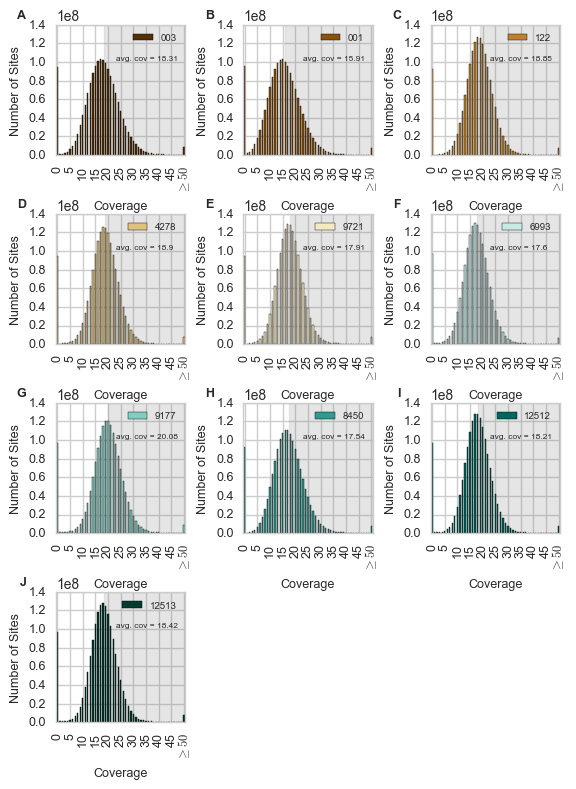

In [127]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
fig=plt.figure(figsize=(6.5,9.0), dpi=100)
fig.subplots_adjust(hspace=0.45,wspace=0.45)
gs = gridspec.GridSpec(4, 3)
row = [0,0,0,1,1,1,2,2,2,3,3,3,]
column = [0,1,2, 0,1,2, 0,1,2, 0,1,2]
letters = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'J']

for i, animal in enumerate(animal_ids): 
    ax = plt.subplot(gs[row[i], column[i]])
    outer_lim = 50
    cov_dist = profCountDF[profCountDF.animal == animal][['cov','occurence']].groupby('cov')['occurence'].sum().reset_index()
    cov_mean = sum(cov_dist['cov'] * cov_dist.occurence)/cov_dist.occurence.sum()
    cov_dist['occurence'][cov_dist['cov'] >= outer_lim] = cov_dist['occurence'][cov_dist['cov'] >= outer_lim].sum()
    cov_dist = cov_dist[cov_dist['cov'] <= outer_lim] 

    ax = cov_dist.plot(x='cov',
                       y='occurence',
                       kind='bar',
                       legend=False,
                       ax=ax, 
                       color=color_ids[animal], 
                       label=change_name(animal), 
                       fontsize=minorFontSize,
                      )
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ticklabels[-1] = r'$\geq%s$'%str(outer_lim)
    ax.xaxis.set_ticks(ticks[::5])
    ax.xaxis.set_ticklabels(ticklabels[::5],rotation=90, fontsize=minorFontSize)
    ax.set_ylabel('Number of Sites', fontsize=minorFontSize)
    ax.set_xlabel('Coverage', fontsize=minorFontSize)
    #ax.set_title( 'Animal:'%change_name(animal), fontsize=minorFontSize)
    ax.set_ylim(0,140000000)
    ax.fill_between((cov_mean, ax.get_xlim()[1]),ax.get_ylim()[0],ax.get_ylim()[1],color='grey',alpha=0.2) 
    ax.text(23,102000000,'avg. cov = %s' % str(round(cov_mean,2)), fontsize=minorFontSize-3)
    
    ax.legend(loc='best',
              ncol=1,
              markerscale=0.2,
              fontsize=minorFontSize-2)
    ax.text(-0.23, 1.12, letters[i], transform=ax.transAxes,
      fontsize=minorFontSize, fontweight='bold', va='top', ha='right')
    
fig.savefig('../fig2/SupplementalFigure5.pdf',bbox_inches='tight',pad_inches=0.1)


## Heterozygosity as a function of coverage (Figure 2A)

In [ ]:
def check_equal_het(row):
    counts = [row['A'],row['T'],row['C'],row['G']]
    non_zero_counts = [n for n in counts if n > 0]
    if len(non_zero_counts)==2 and len(set(non_zero_counts))==1:
        return True
    else:
        return False

In [ ]:
def allele_count(row):
    counts = [row['A'],row['T'],row['C'],row['G']]
    non_zero_counts = [n for n in counts if n > 0]
    non_zero_counts = sorted(non_zero_counts)
    return tuple(non_zero_counts)

In [130]:
profCountDF['allele_count'] = apply_by_multiprocessing(profCountDF, allele_count,8)

In [131]:
profCountDF['equal_het'] = apply_by_multiprocessing(profCountDF,check_equal_het,8)

In [ ]:
def ret_per_cov_equal_rates(prof_count_df):
    tuple_list = []
    for animal in prof_count_df.animal.unique():
        for coverage in range(2, 100, 2):
            grouped = prof_count_df[(prof_count_df.animal == animal) & (prof_count_df['cov'] == coverage)].groupby('equal_het').sum()
            try:
                het = grouped['occurence'][True]
            except IndexError:
                het=0
            try:
                hom = grouped['occurence'][False]
            except IndexError:
                hom = 0
            try:
                rate = float(het)/float(het + hom) * 10000
            except ZeroDivisionError:
                rate = 0
            tuple_list.append((animal, coverage, het, hom, het+hom, rate))

    columns = ['animal','cov','num_equal_het', 'homozygous','total_sites','het_per_10kb']
    per_cov_equal_rates_df = pd.DataFrame(tuple_list)
    per_cov_equal_rates_df.columns = columns
    
    return per_cov_equal_rates_df

In [133]:
perCovEqualRatesDF = ret_per_cov_equal_rates(profCountDF)
perCovEqualRatesDF.head()

,animal,cov,num_equal_het,homozygous,total_sites,het_per_10kb
0,A_tigris8450,2,5583,1012258,1017841,54.851396
1,A_tigris8450,4,1263,3500489,3501752,3.606766
2,A_tigris8450,6,654,10612477,10613131,0.616218
3,A_tigris8450,8,670,25872112,25872782,0.258959
4,A_tigris8450,10,726,49982983,49983709,0.145247


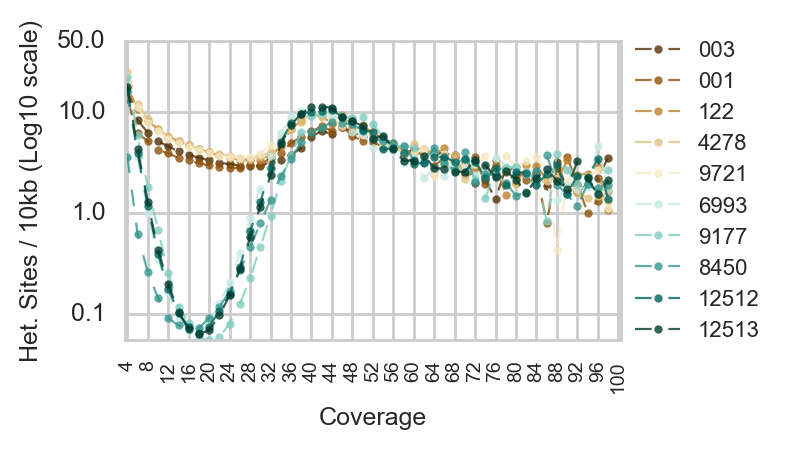

In [135]:
##### sns.set_style("whitegrid", {'axes.grid' : True})
fig = plt.figure(1, figsize=(3.2, 1.93),dpi=200)
#fig = plt.figure(1, figsize=(32, 19.3))

ax = fig.add_subplot(111)

for animal in animal_ids:
    data = perCovEqualRatesDF[(perCovEqualRatesDF.animal == animal) & (perCovEqualRatesDF['cov'] > 2)]
    ax = data.plot(x='cov', 
                    y='het_per_10kb',
                    ylim=(-0.5,18), 
                    xlim = (3.5,100.5), 
                    style='--o', 
                    yticks = np.arange(0,18,1),
                    logy=True,
                    xticks=np.arange(0,102,4),
                    label=change_name(animal), 
                    ax=ax,
                    color=color_ids[animal], 
                    fontsize=minorFontSize, 
                    markersize=3, 
                    linewidth=0.8,
                    alpha=0.8
)
    
    ax.set_ylabel('Het. Sites / 10kb (Log10 scale)', fontsize=minorFontSize)
    ax.set_xlabel('Coverage', fontsize=minorFontSize)
    #ax2.set_title('Rate of Even Split Heterozygous Sites vs Coverage', fontsize=minorFontSize)
    ax.legend(loc=5, bbox_to_anchor=(1.32, 0.5), prop={'size':8})


ax.set_xticklabels(ax.get_xticks(), rotation=90, fontsize=minorFontSize-2);
ax.set_yticks( [0.1,1,10,50])
ax.yaxis.set_major_formatter(ScalarFormatter())
#ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))

fig.savefig('../fig2/Figure3B.pdf', format="pdf",bbox_inches='tight')

## Allele-counts/General genotype support (Figure S7)

In [136]:
def ret_tntv_df(prof_count_df):
    tuple_list = []
    for animal in prof_count_df.animal.unique():
        for cov in xrange(10,26,2):
            temp = prof_count_df[(prof_count_df.status != 'Homozygous') & (prof_count_df.animal == animal) & (prof_count_df['cov'] == cov)].sort_values('allele_count')
            genos = temp['allele_count'].unique().tolist()
            for geno in genos:
                transitions = temp[(temp.status=='Transition')&(temp.allele_count == geno)]['occurence'].sum()
                transversions = temp[(temp.status=='Transversion')&(temp.allele_count == geno)]['occurence'].sum()
                total = temp[temp.allele_count == geno]['occurence'].sum()
                try:
                    ratio = float(transitions)/float(transversions)
                    definable = True
                except ZeroDivisionError:
                    ratio = 0
                    definable = False   
                t = (animal, cov, geno, transitions, transversions, ratio, definable, total)

                tuple_list.append(t)



    tntv_df = pd.DataFrame(tuple_list)
    tntv_df.columns = ['animal','cov','allele_count','transitions','transversions', 'tn_tv_ratio','definable','total']

    return tntv_df

In [137]:
tntvDF = ret_tntv_df(profCountDF)
tntvDF.head()

,animal,cov,allele_count,transitions,transversions,tn_tv_ratio,definable,total
0,A_tigris8450,10,"(1, 1, 1, 7)",0,0,0.0,False,42
1,A_tigris8450,10,"(1, 1, 2, 6)",0,0,0.0,False,17
2,A_tigris8450,10,"(1, 1, 3, 5)",0,0,0.0,False,2
3,A_tigris8450,10,"(1, 1, 8)",0,0,0.0,False,6942
4,A_tigris8450,10,"(1, 2, 2, 5)",0,0,0.0,False,1


In [143]:
tntvDF.animal.unique()

array(['A_tigris8450', 'Atig_122', 'Atig_4278', 'Atig003', 'Atig001',
       'A.tig_12512', 'A.tig_12513', 'A.tig_9721', 'Atig_6993', 'Atig_9177'], dtype=object)

In [144]:
tntvDF['num_alleles'] = tntvDF['allele_count'].apply(lambda x: len(x))
tntvDF.head()

,animal,cov,allele_count,transitions,transversions,tn_tv_ratio,definable,total,num_alleles
0,A_tigris8450,10,"(1, 1, 1, 7)",0,0,0.0,False,42,4
1,A_tigris8450,10,"(1, 1, 2, 6)",0,0,0.0,False,17,4
2,A_tigris8450,10,"(1, 1, 3, 5)",0,0,0.0,False,2,4
3,A_tigris8450,10,"(1, 1, 8)",0,0,0.0,False,6942,3
4,A_tigris8450,10,"(1, 2, 2, 5)",0,0,0.0,False,1,4


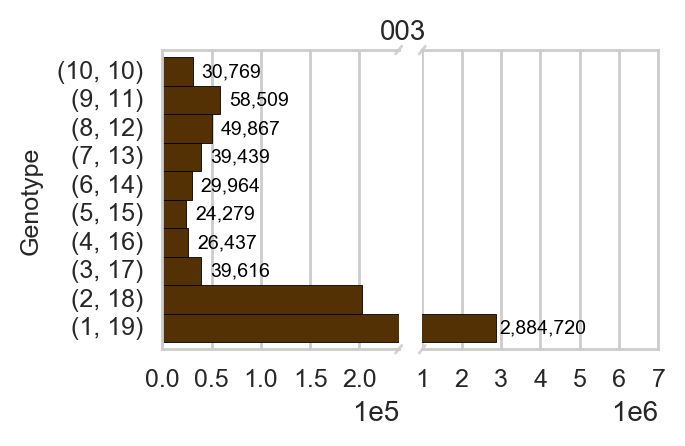

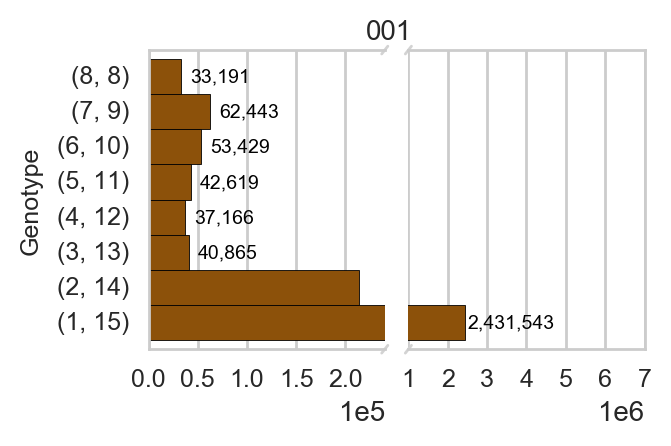

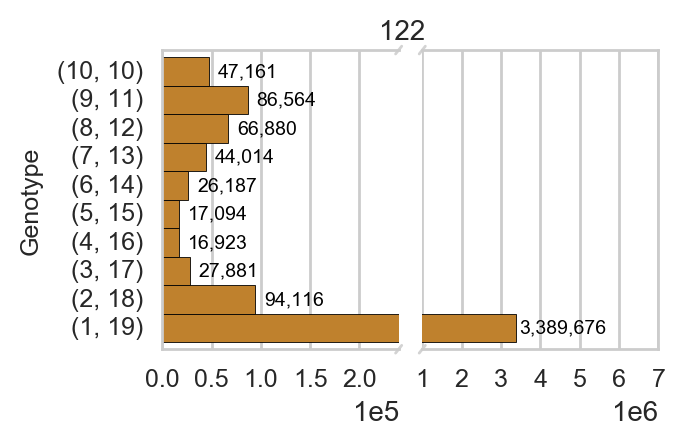

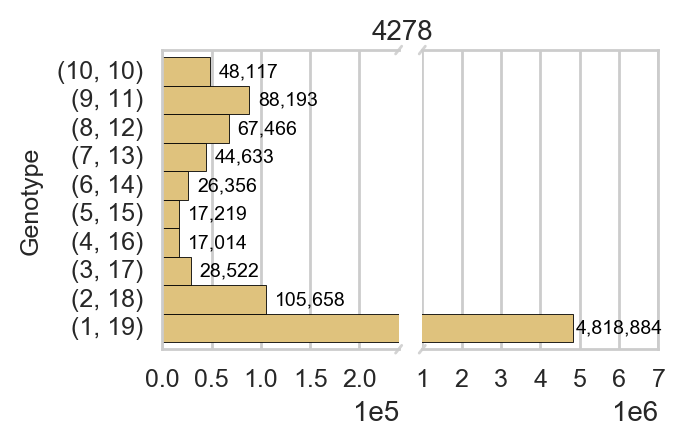

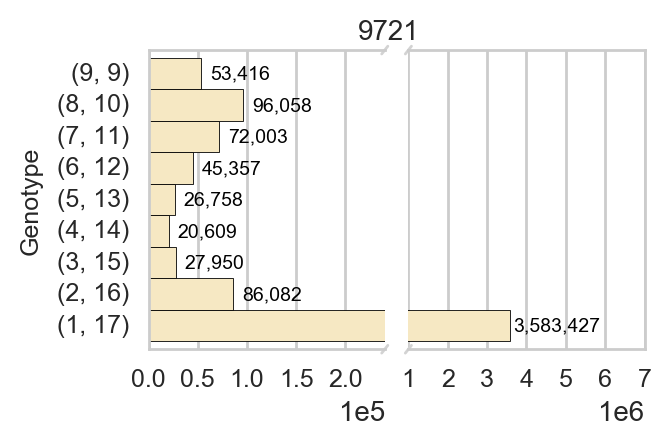

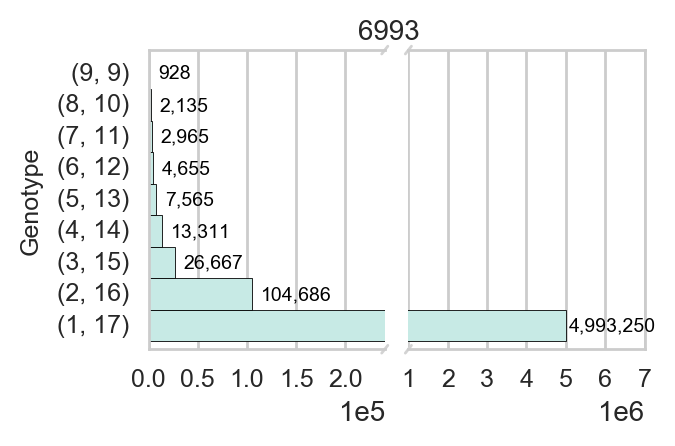

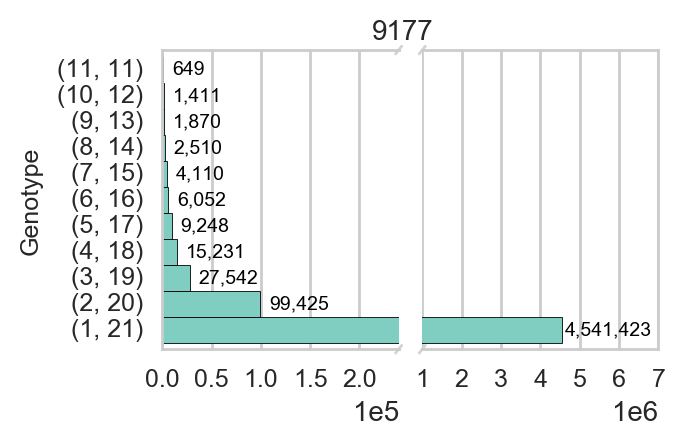

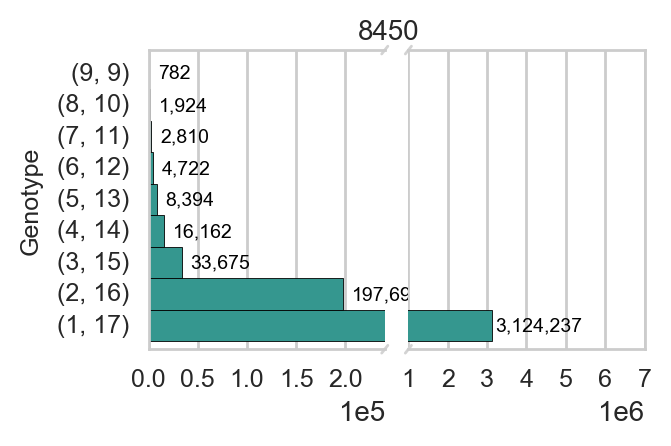

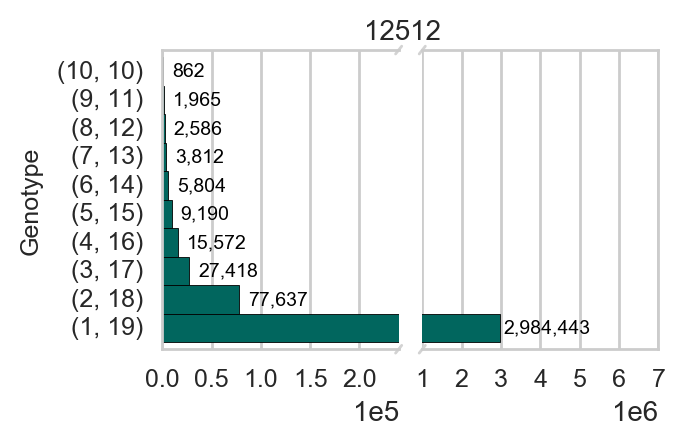

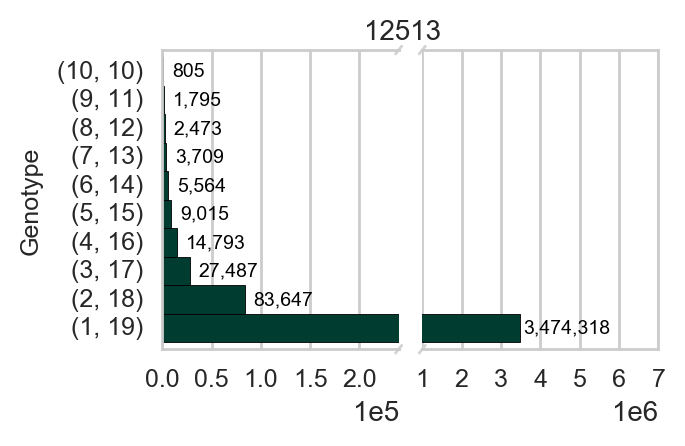

In [146]:
sns.set(font_scale=1.0)
sns.set_style("whitegrid")
letters = ['A', 'B', 'C', 'D', 'E', 'F','G', 'H', 'I', 'J']
for e, animal in enumerate(animal_ids):

    fig,(ax, ax2) = plt.subplots(1, 2, 
                                 sharey=True, 
                                 figsize=(3.2, 1.93), 
                                 dpi=200, 
                                 gridspec_kw = {'wspace':0.1, 'hspace':0}
                                )


    fig.suptitle(id_to_name[animal], fontsize=majorFontSize)
    
    data = tntvDF[(tntvDF['cov']==covValuesDict[animal]) & \
                  (tntvDF['animal']==animal) & \
                  (tntvDF.num_alleles < 3)]
#     imp_total = data.loc[data['num_alleles'] > 2,'total'].sum()
    
#     temp = data[data.num_alleles < 3][['animal', 'total', 'allele_count']]
 
#     new_row = pd.DataFrame([{'animal': animal ,'allele_count':'Alleles > 2', 'total': imp_total}])
#     data = pd.concat([temp,new_row])
 

    

    data.plot(x='allele_count', y='total', kind='barh', width=1, color=color_ids[animal], ax=ax, legend=False)
    data.plot(x='allele_count', y='total', kind='barh', width=1, color=color_ids[animal], ax=ax2, legend=False)

    ax2.set_xlim(1000000,7000000)
    ax.set_xlim(0,240000)
    
    ax.yaxis.grid(False)
    ax2.yaxis.grid(False)
    

    ax.ticklabel_format(style='sci',scilimits=(-3,4),axis='x',useOffset=False, fontsize=minorFontSize)
    ax2.ticklabel_format(style='sci',scilimits=(-3,4),axis='x',useOffset=False, fontsize=minorFontSize)

    ax.set_ylabel('Genotype')

    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    for i, v in enumerate(data.total):
        if v < 200000:
            ax.text(v+9000, i,
                     "{:,}".format(v), 
                     color='black',
                     #fontweight='bold',
                     fontsize=minorFontSize - 2,
                     horizontalalignment='left', 
                     verticalalignment='center', 
                     rotation=0)
        elif v > 1000000:
            ax2.text(v + 80000, i,
                    "{:,}".format(v), 
                    color='black',
                    fontsize=minorFontSize - 2,
                    #fontweight='bold', 
                    horizontalalignment='left', 
                    verticalalignment='center',
                    rotation=0)

    d = .013 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='lightgrey', clip_on=False, lw=1.0)
    ax.plot((1-d,1+d),(-d,+d), **kwargs) # top-left diagonal
    ax.plot((1-d,1+d),(1-d,1+d), **kwargs) # bottom-left diagonal

    kwargs.update(transform=ax2.transAxes) # switch to the bottom axes
    ax2.plot((-d,d),(-d,+d), **kwargs) # top-right diagonal
    ax2.plot((-d,d),(1-d,1+d), **kwargs) # bottom-right diagonal
    


    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(minorFontSize)
    
    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] + ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(minorFontSize)
    
    ax.yaxis.get_offset_text().set_size(minorFontSize-2)
    ax2.yaxis.get_offset_text().set_size(minorFontSize-2)
    
    fig.savefig('../fig2/SupplementalFigure6%s.pdf' % letters[e], format="pdf",bbox_inches='tight')
    plt.show()
    
#     if animal == 'Atig_122':
#         fig.savefig('../fig2/Figure3C.pdf', format="pdf",bbox_inches='tight')
#     elif animal == 'A_tigris8450':
#         fig.savefig('../fig2/Figure3D.pdf', format="pdf",bbox_inches='tight')

## Distribution of Genome Average Even Heterozygous Sites (Figure 2B)

In [147]:
covValuesDict

{'A.tig_12512': 20,
 'A.tig_12513': 20,
 'A.tig_9721': 18,
 'A_tigris8450': 18,
 'Atig001': 16,
 'Atig003': 20,
 'Atig_122': 20,
 'Atig_4278': 20,
 'Atig_6993': 18,
 'Atig_9177': 22}

In [148]:
%%bash

# awk '$7==16' ../data/pysam/Atig001.merged.dedup.realigned.prof.not_hom > ../data/pysam/Atig001.merged.dedup.realigned.prof.avg_cov &
# awk '$7==20' ../data/pysam/Atig003.merged.dedup.realigned.prof.not_hom > ../data/pysam/Atig003.merged.dedup.realigned.prof.avg_cov &
# awk '$7==20' ../data/pysam/Atig_122.merged.dedup.realigned.prof.not_hom > ../data/pysam/Atig_122.merged.dedup.realigned.prof.avg_cov &
# awk '$7==20' ../data/pysam/A.tig_12512.merged.dedup.realigned.prof.not_hom > ../data/pysam/A.tig_12512.merged.dedup.realigned.prof.avg_cov &
# awk '$7==20' ../data/pysam/A.tig_12513.merged.dedup.realigned.prof.not_hom > ../data/pysam/A.tig_12513.merged.dedup.realigned.prof.avg_cov &
# awk '$7==20' ../data/pysam/Atig_4278.merged.dedup.realigned.prof.not_hom > ../data/pysam/Atig_4278.merged.dedup.realigned.prof.avg_cov &
# awk '$7==18' ../data/pysam/Atig_6993.merged.dedup.realigned.prof.not_hom > ../data/pysam/Atig_6993.merged.dedup.realigned.prof.avg_cov &
# awk '$7==22' ../data/pysam/Atig_9177.merged.dedup.realigned.prof.not_hom > ../data/pysam/Atig_9177.merged.dedup.realigned.prof.avg_cov &
# awk '$7==18' ../data/pysam/A.tig_9721.merged.dedup.realigned.prof.not_hom > ../data/pysam/A.tig_9721.merged.dedup.realigned.prof.avg_cov &
# awk '$7==18' ../data/pysam/A_tigris8450.merged.dedup.realigned.prof.not_hom > ../data/pysam/A_tigris8450.merged.dedup.realigned.prof.avg_cov &

In [149]:
%%bash
head ../data/pysam/Atig001.merged.dedup.realigned.prof.not_hom
head ../data/pysam/Atig001.merged.dedup.realigned.prof.avg_cov

chrom	pos	A	C	G	T	cov	status
Scpiz6a_49	6	0	49	7	37	93	Unknown
Scpiz6a_49	10	0	86	3	7	96	Unknown
Scpiz6a_49	11	1	47	51	0	99	Unknown
Scpiz6a_49	12	0	3	0	115	118	Transition
Scpiz6a_49	16	3	0	131	0	134	Transition
Scpiz6a_49	17	0	54	80	0	134	Transversion
Scpiz6a_49	18	6	8	0	146	160	Unknown
Scpiz6a_49	23	4	0	177	0	181	Transition
Scpiz6a_49	24	0	176	0	6	182	Transition
Scpiz6a_49	557	10	0	6	0	16	Transition
Scpiz6a_49	2067	0	0	14	2	16	Transversion
Scpiz6a_49	2875	15	0	1	0	16	Transition
Scpiz6a_49	3485	0	1	0	15	16	Transition
Scpiz6a_49	3488	0	1	15	0	16	Transversion
Scpiz6a_49	3489	0	0	1	15	16	Transversion
Scpiz6a_49	3491	0	0	15	1	16	Transversion
Scpiz6a_49	3521	15	0	0	1	16	Transversion
Scpiz6a_49	4234	1	0	15	0	16	Transition
Scpiz6a_49	4235	1	15	0	0	16	Transversion


In [150]:
df_list = []
for animal in animal_ids:
    df = pd.read_csv('../data/pysam/%s.merged.dedup.realigned.prof.avg_cov' % animal, sep='\t',names=['chrom','pos','A','C','G','T','cov','status'])
    df['animal'] = animal
    df_list.append(df)
    
avgCovHetSitesDF = pd.concat(df_list,axis=0)
avgCovHetSitesDF.head()

,chrom,pos,A,C,G,T,cov,status,animal
0,Scpiz6a_49,651,19,1,0,0,20,Transversion,Atig003
1,Scpiz6a_49,2292,0,1,0,19,20,Transition,Atig003
2,Scpiz6a_49,3000,19,0,0,1,20,Transversion,Atig003
3,Scpiz6a_49,5047,0,1,0,19,20,Transition,Atig003
4,Scpiz6a_49,5864,0,1,0,19,20,Transition,Atig003


In [151]:
avgCovHetSitesDF['allele_count'] = apply_by_multiprocessing(avgCovHetSitesDF, allele_count,8)
avgCovHetSitesDF.head()

,chrom,pos,A,C,G,T,cov,status,animal,allele_count
0,Scpiz6a_49,651,19,1,0,0,20,Transversion,Atig003,"(1, 19)"
1,Scpiz6a_49,2292,0,1,0,19,20,Transition,Atig003,"(1, 19)"
2,Scpiz6a_49,3000,19,0,0,1,20,Transversion,Atig003,"(1, 19)"
3,Scpiz6a_49,5047,0,1,0,19,20,Transition,Atig003,"(1, 19)"
4,Scpiz6a_49,5864,0,1,0,19,20,Transition,Atig003,"(1, 19)"


In [152]:
avgCovHetSitesDF['equal'] = avgCovHetSitesDF['allele_count'].apply(lambda x: x[0] == x[1] and len(x)==2)
avgCovEqualHetSitesDF = avgCovHetSitesDF[avgCovHetSitesDF['equal']==True].reset_index(drop=True)
avgCovEqualHetSitesDF.head()

,chrom,pos,A,C,G,T,cov,status,animal,allele_count,equal
0,Scpiz6a_49,357652,0,10,0,10,20,Transition,Atig003,"(10, 10)",True
1,Scpiz6a_49,533563,0,10,0,10,20,Transition,Atig003,"(10, 10)",True
2,Scpiz6a_49,533564,10,10,0,0,20,Transversion,Atig003,"(10, 10)",True
3,Scpiz6a_49,1076362,10,0,0,10,20,Transversion,Atig003,"(10, 10)",True
4,Scpiz6a_49,1258626,10,0,10,0,20,Transition,Atig003,"(10, 10)",True


In [153]:
scaffoldSizes['genome_scale'] = scaffoldSizes.scaffold_size.cumsum()
scaffoldSizes.genome_scale = scaffoldSizes.genome_scale.shift(1)
scaffoldSizes.fillna(value=0, inplace=True)
scaffoldScaleDict = dict(zip(scaffoldSizes.scaffold.tolist(), scaffoldSizes.genome_scale.tolist()))
display(scaffoldSizes.head())


,scaffold,scaffold_size,genome_scale
3825,Scpiz6a_49,85027298,0.0
3824,Scpiz6a_55.1,77407970,85027298.0
3823,Scpiz6a_26,75278123,162435268.0
3822,Scpiz6a_73,74911545,237713391.0
3821,Scpiz6a_37,69231668,312624936.0


In [154]:
avgCovEqualHetSitesDF['genome_pos'] = avgCovEqualHetSitesDF.apply(lambda row: row['pos'] + scaffoldScaleDict[row['chrom']], axis=1)
avgCovEqualHetSitesDF['height']=[np.random.choice(a=np.arange(0.0,1.0,0.05)) for n in range(len(avgCovEqualHetSitesDF))]
avgCovEqualHetSitesDF['chrom_size'] = avgCovEqualHetSitesDF['chrom'].apply(lambda x: scaffoldSizeDict[x])
avgCovEqualHetSitesDF.head()

,chrom,pos,A,C,G,T,cov,status,animal,allele_count,equal,genome_pos,height,chrom_size
0,Scpiz6a_49,357652,0,10,0,10,20,Transition,Atig003,"(10, 10)",True,357652.0,0.55,85027298
1,Scpiz6a_49,533563,0,10,0,10,20,Transition,Atig003,"(10, 10)",True,533563.0,0.15,85027298
2,Scpiz6a_49,533564,10,10,0,0,20,Transversion,Atig003,"(10, 10)",True,533564.0,0.10,85027298
3,Scpiz6a_49,1076362,10,0,0,10,20,Transversion,Atig003,"(10, 10)",True,1076362.0,0.85,85027298
4,Scpiz6a_49,1258626,10,0,10,0,20,Transition,Atig003,"(10, 10)",True,1258626.0,0.10,85027298


In [155]:
avgCovEqualHetSitesDF[avgCovEqualHetSitesDF['chrom'] =='Scpiz6a_45'].groupby('animal').count()

,chrom,pos,A,C,G,T,cov,status,allele_count,equal,genome_pos,height,chrom_size
animal,,,,,,,,,,,,,
A.tig_12512,38,38,38,38,38,38,38,38,38,38,38,38,38
A.tig_12513,29,29,29,29,29,29,29,29,29,29,29,29,29
A.tig_9721,952,952,952,952,952,952,952,952,952,952,952,952,952
A_tigris8450,41,41,41,41,41,41,41,41,41,41,41,41,41
Atig001,629,629,629,629,629,629,629,629,629,629,629,629,629
Atig003,610,610,610,610,610,610,610,610,610,610,610,610,610
Atig_122,848,848,848,848,848,848,848,848,848,848,848,848,848
Atig_4278,807,807,807,807,807,807,807,807,807,807,807,807,807
Atig_6993,26,26,26,26,26,26,26,26,26,26,26,26,26


10
30440
32832
46773
47695
52945
878
598
716
806


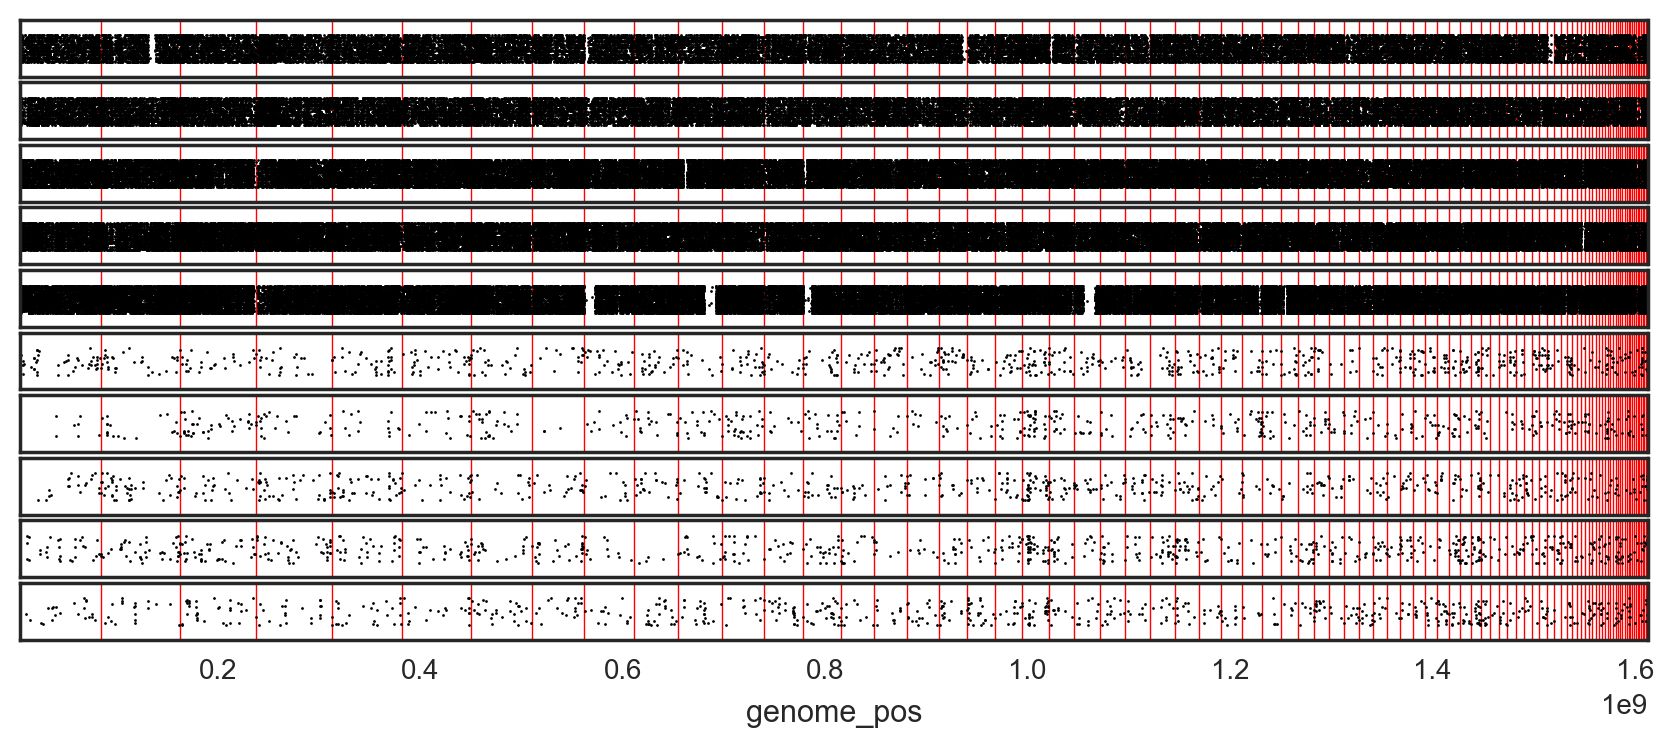

In [156]:
sns.set(style='white')
fig,axarr = plt.subplots(10, 1, 
    sharex=True, 
    figsize=(10.5, 4), 
    dpi=200, 
    gridspec_kw = {'wspace':0.0, 'hspace':0.1}
)
for i, animal in enumerate(avgCovEqualHetSitesDF.animal.unique()):
    print(len(data))
    data = avgCovEqualHetSitesDF[(avgCovEqualHetSitesDF.animal == animal) & (avgCovEqualHetSitesDF.chrom_size > 1e6)]
    ax = data.plot('genome_pos', 'height', style ='.', marker='.', markersize=2, color='black', legend=False, ax=axarr[i])
    ax.set_ylim(-0.5,1.5)
    ax.set_yticks([])
    ax.vlines(x=scaffoldSizes[scaffoldSizes.scaffold_size > 1e6].genome_scale, ymin=-0.5, ymax=1.5,lw=0.5,linestyles='solid',color='red')
    
plt.show()

## Het sites across the genome

### Pysam 10kb Non-Overlapping Windows (Figure 2C)

In [ ]:
# %load ../bin/scan_profile_no_lim.py
#!/usr/bin/env python
#Author: Duncan Tormey
#Email: dut@stowers.org or duncantormey@gmail.com
##################################################
# This script takes the  tsv output from         #
# pysam_profiler.py and applies a 10Kb sliding   #
# window accross each scaffod, counting sites as #
# heterozygous if the pass the conditions of the #
# function is_het. This script is currently hard #
# coded for my data.                             #
##################################################

from __future__ import print_function
from __future__ import division
import pandas as pd
import multiprocessing as mp
import numpy as np

def apply_df(df, func, *args):
    return df.apply(lambda x: func(x, *args), axis=1)


def apply_by_multiprocessing(df, func, workers, *args):
    pool = mp.Pool(processes=workers)
    result = [pool.apply_async(apply_df, args = (d, func) + args) for d in np.array_split(df, workers)]
    output = [p.get() for p in result]
    pool.close()
    return pd.concat(output)



def check_equal_het(row):
    counts = [row['A'],row['T'],row['C'],row['G']]
    non_zero_counts = [n for n in counts if n > 0]
    if len(non_zero_counts)==2 and len(set(non_zero_counts))==1:
        return True
    else:
        return False


def is_het(row, avg_cov):
    if row['cov'] <= 8:
        return False
    elif check_equal_het(row):
        return True
    else:
        return False


def load_het_profiles(path, cpus, avg_cov):
    het_profs = pd.read_csv(path,sep='\t',header=0)
    #het_profs['is_het'] = het_profs.apply(lambda row: is_het(row, avg_cov))
    het_profs['is_het'] = apply_by_multiprocessing(het_profs, is_het, cpus, avg_cov) #this broke with all sites
    het_profs[het_profs['is_het']==True].to_csv(path + '.is_het8.nolim',sep = '\t', index=False)
    
    return het_profs


def return_window_df(het_profs, scaffold_sizes, window=10000):
    windows = []
    append = windows.append
    for scaffold in het_profs.chrom.unique():
        scaffold_data = het_profs[het_profs.chrom == scaffold]
        scaffold_size = scaffold_sizes[scaffold_sizes.scaffold == scaffold]['scaffold_size'].values[0]
        for i in xrange(0,scaffold_size, window):
            if i+window <= scaffold_size:
                num_het = scaffold_data[(scaffold_data['pos']>=i)&(scaffold_data['pos']<i+window)]['is_het'].sum()
                size = window
            else:
                num_het = scaffold_data[scaffold_data['pos']>i]['is_het'].sum()
                size = len(scaffold_data[scaffold_data['pos']>i])

            append((scaffold, i, num_het, size))

    window_df = pd.DataFrame(windows, columns = ['chrom','window_start', 'het_sites','window_size'])
    
    return window_df
    
def write_window_df(het_prof_path, avg_cov, scaffold_sizes_path, cpus, window=10000):
    scaffold_sizes = pd.read_csv(scaffold_sizes_path,sep='\t', names = ['scaffold','scaffold_size'])
    het_profs = load_het_profiles(het_prof_path, cpus, avg_cov)
    window_df = return_window_df(het_profs, scaffold_sizes, window)
    window_df.to_csv(het_prof_path+'.%skbwindows8.nolim.tsv' % str(window/1000), sep='\t',index=False)
    return None

if __name__ == '__main__':
    scaffold_sizes_path = '/home/dut/projects/tigris/genome_annotation/fasta/scaffold_sizes.clean.tsv'

    paths =['/n/projects/dut/a_marmorata/parthenogen_heterozygosity/data/pysam/Atig001.merged.dedup.realigned.prof.not_hom',
            '/n/projects/dut/a_marmorata/parthenogen_heterozygosity/data/pysam/Atig003.merged.dedup.realigned.prof.not_hom',
            '/n/projects/dut/a_marmorata/parthenogen_heterozygosity/data/pysam/Atig_122.merged.dedup.realigned.prof.not_hom',
            '/n/projects/dut/a_marmorata/parthenogen_heterozygosity/data/pysam/A_tigris8450.merged.dedup.realigned.prof.not_hom']

    avg_covs = [16, 18,19,18]
    for path, avg_cov in zip(paths, avg_covs):
        print(path)
        write_window_df(path, avg_cov, scaffold_sizes_path, 8, 10000)

In [ ]:
equalWindowPaths = {
    'Atig001': '../data/pysam/Atig001.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
    'A_tigris8450': '../data/pysam/A_tigris8450.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
    'Atig003': '../data/pysam/Atig003.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
    'Atig_122': '../data/pysam/Atig_122.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
    'A.tig_12512': '../data/pysam/A.tig_12512.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
    'A.tig_12513': '../data/pysam/A.tig_12513.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
    'A.tig_9721': '../data/pysam/A.tig_9721.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
    'Atig_4278': '../data/pysam/Atig_4278.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
    'Atig_6993': '../data/pysam/Atig_6993.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
    'Atig_9177': '../data/pysam/Atig_9177.merged.dedup.realigned.prof.not_hom.10.0kbwindows8.nolim.tsv',
}

In [ ]:
def ret_equal_het_windows(window_paths):
    for i, sample_name in enumerate(window_paths):        
        path = window_paths[sample_name]
        window_df = pd.read_csv(path, sep='\t')
        window_df['animal'] = sample_name
        if i == 0:
            df_equal_het_windows = window_df
        else:
            df_equal_het_windows = pd.concat([df_equal_het_windows, window_df])

        print(len(df_equal_het_windows), i, path, sample_name)
        
    return df_equal_het_windows

In [ ]:
equalHetWindowsDF = ret_equal_het_windows(equalWindowPaths)

In [ ]:
equalHetWindowsDF['chrom_size'] = equalHetWindowsDF.chrom.apply(lambda x: scaffoldSizeDict[x])

In [ ]:
equalHetWindowsDF.sort_values(['animal','chrom_size', 'window_start'], ascending=[True, False, True], inplace=True)
equalHetWindowsDF.head()

In [ ]:
step=500
fig,axarr = plt.subplots(3, 1, 
    sharex=True, 
    figsize=(6.2, 3), 
    dpi=200, 
    gridspec_kw = {'wspace':0.0, 'hspace':0.1}
)
for i, family in enumerate([family_1, family_2]):
    ax=axarr[i]
    for animal in family:
        five_mb_rolling = equalHetWindowsDF[(equalHetWindowsDF['animal']==animal) & (equalHetWindowsDF['chrom_size']>5e5)].reset_index().het_sites.rolling(window=step)

        five_mb_rolling.mean().plot(legend=False, 
                                          rot = 90, 
                                          #style='.', 
                                          linewidth=0.8,
                                          ax=ax, 
                                          label=id_to_name[animal], 
                                          color=family_colors[animal], 
                                          #markersize=1.0,
                                          alpha=0.7,
                                          fontsize=minorFontSize,
                                         rasterized=True)

        ax.fill_between(five_mb_rolling.mean().index, 
                         five_mb_rolling.mean()-2*five_mb_rolling.std()/np.sqrt(step), 
                         five_mb_rolling.mean()+2*five_mb_rolling.std()/np.sqrt(step), 
                         color=family_colors[animal], 
                         alpha=0.3,
                        rasterized=True)
    
    ax.set_yticks(np.arange(0,4.0,1.0))
    megabase_labels = [str((x*10000/1000000000)) for x in ax.get_xticks()]
    #ax.set_title('Genome Wide Heterozygosity 5Mb Sliding Window', fontsize=minorFontSize)
    ax.set_xticklabels(megabase_labels, rotation=90, fontsize=minorFontSize)
    
    ax.set_xlabel('Window Start Position (Gb)', fontsize=minorFontSize)
    #ax.set_ylabel('Avg. Het. Sites / 10kb', fontsize=minorFontSize-3)
    ax.set_ylim(-0.1,3.5)
    ax.legend(loc=5, bbox_to_anchor=(1.20, 0.5), markerscale=5, fontsize=minorFontSize)

fig.text(0.04, 0.5, 'Avg. Het. Sites / 10kb', ha='center', va='center', fontsize=minorFontSize, rotation='vertical')
fig.savefig('../fig2/Figure4A.pdf', format="pdf",bbox_inches='tight')

# V2R Copy Number analysis MAKER Annotations (Figure S8)

This first table I am reading in shows the copy number variation for every gene annotated in the MAKER annotations.

In [181]:
gffCopyNumMarmDF = pd.read_csv('../../dovetail_vomeronasal/data/annotCopyNumsDF.tsv', sep='\t')
gffCopyNumMarmDF = gffCopyNumMarmDF[gffCopyNumMarmDF.type=="gene"]
gffCopyNumMarmDF.cnv.fillna('CN1',inplace=True)
gffCopyNumMarmDF['copies'] = gffCopyNumMarmDF['cnv'].apply(lambda x: int(x[2]))
gffCopyNumMarmDF.head()

,seqnames,start,end,width,strand,source,type,score,phase,ID,...,Note,Dbxref,Parent,X_AED,X_QI,X_eAED,Ontology_term,score.1,cnv,copies
0,Scpiz6a_1,69274,86971.0,17698,+,maker,gene,NaN,NaN,gene1,...,Similar to LYPD6: Ly6/PLAUR domain-containing protein 6 (Homo sapiens),"c(""Gene3D:G3DSA:2.10.60.10"", ""SUPERFAMILY:SSF57302"")",character(0),NaN,NaN,NaN,character(0),NaN,CN1,1
11,Scpiz6a_1,105656,124326.0,18671,-,maker,gene,NaN,NaN,gene2,...,"Similar to MMADHC: Methylmalonic aciduria and homocystinuria type D homolog, mitochondrial (Gallus gallus)","c(""InterPro:IPR019362"", ""Pfam:PF10229"")",character(0),NaN,NaN,NaN,GO:0009235,NaN,CN1,1
40,Scpiz6a_1,458899,468953.0,10055,-,maker,gene,NaN,NaN,gene3,...,Similar to Rnd3: Rho-related GTP-binding protein RhoE (Rattus norvegicus),"c(""Gene3D:G3DSA:3.40.50.300"", ""InterPro:IPR001806"", ""InterPro:IPR003578"", ""InterPro:IPR003579"", ""InterPro:IPR027417"", ""Pfam:PF00071"", ""ProSiteProfiles:PS51420"", ""SMART:SM00174"", ""SMART:SM00175"", ""SUPERFAMILY:SSF52540"")",character(0),NaN,NaN,NaN,"c(""GO:0005525"", ""GO:0005622"", ""GO:0007264"", ""GO:0015031"")",NaN,CN1,1
50,Scpiz6a_1,609021,609749.0,729,-,maker,gene,NaN,NaN,gene4,...,Protein of unknown function,"c(""Gene3D:G3DSA:1.10.443.10"", ""InterPro:IPR011010"", ""InterPro:IPR013762"", ""SUPERFAMILY:SSF56349"")",character(0),NaN,NaN,NaN,"c(""GO:0003677"", ""GO:0006310"", ""GO:0015074"")",NaN,CN1,1
54,Scpiz6a_1,677616,678006.0,391,-,maker,gene,NaN,NaN,gene5,...,Similar to rgr-1: Mediator of RNA polymerase II transcription subunit 14 (Caenorhabditis briggsae),character(0),character(0),NaN,NaN,NaN,character(0),1246.0,CN1,1


Next I add a column to contain the gene symbol.

In [182]:
gffCopyNumMarmDF['gene_symbol'] = gffCopyNumMarmDF['Note'].apply(lambda x: x.replace('Similar to ', '').split(':')[0])
gffCopyNumMarmDF['gene_symbol'].head()

0     LYPD6                      
11    MMADHC                     
40    Rnd3                       
50    Protein of unknown function
54    rgr-1                      
Name: gene_symbol, dtype: object

Here I number of times each gene symbol occurs genome wide. Only gene symbols that occur more than 10 times are shown.

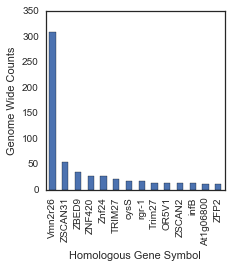

In [183]:
fig = plt.figure(1, figsize=(3.2, 3.2))
ax = fig.add_subplot(111)
value_counts = pd.DataFrame(gffCopyNumMarmDF[gffCopyNumMarmDF['gene_symbol'] != "Protein of unknown function"]['gene_symbol'].value_counts())
data = value_counts[value_counts.gene_symbol > 10]
data.plot(kind='bar', ax=ax, legend=False)
ax.set_ylabel('Genome Wide Counts')
ax.set_xlabel('Homologous Gene Symbol')
fig.savefig('../fig/vmnr_maker_all_counts.pdf', bbox_inches='tight')

Here are the numbers from that plot. Vmn2r26 occurs 309 times genome wide.

In [184]:
data

,gene_symbol
Vmn2r26,309
ZSCAN31,55
ZBED9,35
ZNF420,28
Znf24,28
TRIM27,21
cysS,18
rgr-1,17
Trim27,14
OR5V1,13


Here I generate the same plot as above, but only for scaffold 45 (which is the scaffold that shows increased apparent heterozygosity). Only symbols 4 or more occurences are shown.

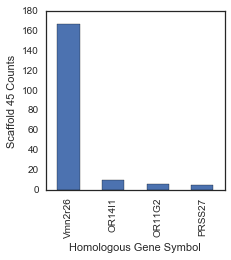

In [185]:
fig = plt.figure(1, figsize=(3.2, 3.2))
ax = fig.add_subplot(111)
value_counts = pd.DataFrame(gffCopyNumMarmDF[(gffCopyNumMarmDF['gene_symbol'] != "Protein of unknown function") & (gffCopyNumMarmDF.seqnames =='Scpiz6a_45')]['gene_symbol'].value_counts())
data = value_counts[value_counts.gene_symbol > 4]
data.plot(kind='bar', ax=ax, legend=False)
ax.set_ylabel('Scaffold 45 Counts')
ax.set_xlabel('Homologous Gene Symbol')
fig.savefig('../fig/vmnr_maker_45_counts.pdf', bbox_inches='tight')

Here is the data for this plot. Vmn2r26 occurs 177 time on scaffold 45.

In [186]:
data

,gene_symbol
Vmn2r26,167
OR14I1,10
OR11G2,6
PRSS27,5


Here I save the subsetted table for all Vmn2r26 that are on scaffold 45.

In [187]:
vmnrGffCopyDF = gffCopyNumMarmDF[(gffCopyNumMarmDF.Note.str.contains('Vmn2r26',case=False)) & (gffCopyNumMarmDF.seqnames =='Scpiz6a_45')].reset_index().copy()
vmnrGffCopyDF.head()

,index,seqnames,start,end,width,strand,source,type,score,phase,...,Dbxref,Parent,X_AED,X_QI,X_eAED,Ontology_term,score.1,cnv,copies,gene_symbol
0,465598,Scpiz6a_45,5125710,5235885.0,110176,+,maker,gene,NaN,NaN,...,"c(""Gene3D:G3DSA:3.40.50.2300"", ""InterPro:IPR000337"", ""InterPro:IPR001828"", ""InterPro:IPR004073"", ""InterPro:IPR011500"", ""InterPro:IPR017978"", ""InterPro:IPR017979"", ""InterPro:IPR028082"", ""PRINTS:PR00248"", ""PRINTS:PR01535"", ""Pfam:PF00003"", ""Pfam:PF01094"", ""Pfam:PF07562"", ""ProSitePatterns:PS00981"", ""ProSiteProfiles:PS50259"", ""SUPERFAMILY:SSF53822"", ""SUPERFAMILY:SSF81665"")",character(0),NaN,NaN,NaN,"c(""GO:0004930"", ""GO:0007186"", ""GO:0016021"")",NaN,CN1,1,Vmn2r26
1,465885,Scpiz6a_45,5243577,5320649.0,77073,-,maker,gene,NaN,NaN,...,"c(""Gene3D:G3DSA:3.40.50.2300"", ""InterPro:IPR000337"", ""InterPro:IPR001828"", ""InterPro:IPR004073"", ""InterPro:IPR011500"", ""InterPro:IPR017978"", ""InterPro:IPR017979"", ""InterPro:IPR028082"", ""PRINTS:PR00248"", ""PRINTS:PR01535"", ""Pfam:PF00003"", ""Pfam:PF01094"", ""Pfam:PF07562"", ""ProSitePatterns:PS00981"", ""ProSiteProfiles:PS50259"", ""SUPERFAMILY:SSF53822"", ""SUPERFAMILY:SSF81665"")",character(0),NaN,NaN,NaN,"c(""GO:0004930"", ""GO:0007186"", ""GO:0016021"")",NaN,CN1,1,Vmn2r26
2,466138,Scpiz6a_45,5332681,5367671.0,34991,-,maker,gene,NaN,NaN,...,"c(""Gene3D:G3DSA:3.40.50.2300"", ""InterPro:IPR000337"", ""InterPro:IPR001828"", ""InterPro:IPR004073"", ""InterPro:IPR011500"", ""InterPro:IPR017978"", ""InterPro:IPR017979"", ""InterPro:IPR028082"", ""PRINTS:PR00248"", ""PRINTS:PR01535"", ""Pfam:PF00003"", ""Pfam:PF01094"", ""Pfam:PF07562"", ""ProSitePatterns:PS00981"", ""ProSiteProfiles:PS50259"", ""SUPERFAMILY:SSF53822"")",character(0),NaN,NaN,NaN,"c(""GO:0004930"", ""GO:0007186"", ""GO:0016021"")",NaN,CN1,1,Vmn2r26
3,466383,Scpiz6a_45,5374537,5392755.0,18219,+,maker,gene,NaN,NaN,...,"c(""Gene3D:G3DSA:3.40.50.2300"", ""InterPro:IPR000337"", ""InterPro:IPR001828"", ""InterPro:IPR004073"", ""InterPro:IPR011500"", ""InterPro:IPR017978"", ""InterPro:IPR017979"", ""InterPro:IPR028082"", ""PRINTS:PR00248"", ""PRINTS:PR01535"", ""Pfam:PF00003"", ""Pfam:PF01094"", ""Pfam:PF07562"", ""ProSitePatterns:PS00981"", ""ProSiteProfiles:PS50259"", ""SUPERFAMILY:SSF53822"")",character(0),NaN,NaN,NaN,"c(""GO:0004930"", ""GO:0007186"", ""GO:0016021"")",NaN,CN1,1,Vmn2r26
4,466470,Scpiz6a_45,5509516,5545895.0,36380,+,maker,gene,NaN,NaN,...,"c(""Gene3D:G3DSA:3.40.50.2300"", ""InterPro:IPR000337"", ""InterPro:IPR001828"", ""InterPro:IPR004073"", ""InterPro:IPR011500"", ""InterPro:IPR017978"", ""InterPro:IPR017979"", ""InterPro:IPR028082"", ""PRINTS:PR00248"", ""PRINTS:PR01535"", ""Pfam:PF00003"", ""Pfam:PF01094"", ""Pfam:PF07562"", ""ProSitePatterns:PS00981"", ""ProSiteProfiles:PS50259"", ""SUPERFAMILY:SSF53822"")",character(0),NaN,NaN,NaN,"c(""GO:0004930"", ""GO:0007186"", ""GO:0016021"")",NaN,CN1,1,Vmn2r26


In this next section I compare the compy number estimations in 8450 to the number of annotations present in the genome assembly 

There are 323 copies of Vmn2r26 in 8450, according to the MAKER gene annotations and the copy number variation analysis. 

In [188]:
gffCopyNumMarmDF[(gffCopyNumMarmDF.type == 'gene') & (gffCopyNumMarmDF.Note.str.contains('Vmn2r26',case=False))].copies.sum()

323

Of the 323 copies, 177 reside on scaffold 45.

In [189]:
vmnrGffCopyDF.copies.sum()

177

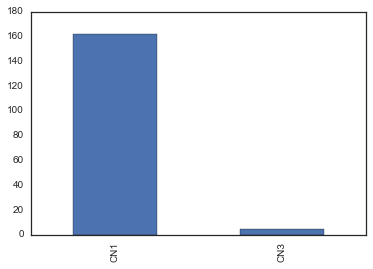

In [190]:
vmnrGffCopyDF.cnv.value_counts().plot(kind='bar')

In [191]:
vmnrDF = gffMarmDF[(gffMarmDF.feature == 'gene') & (gffMarmDF.gene_symbol=='Vmn2r26') & (gffMarmDF.seqid =='Scpiz6a_45')].copy()
vmnrDF['width'] = vmnrDF['end'] - vmnrDF['start']
vmnrDF['broken_bars'] = vmnrDF.apply(lambda row: (row['start']/10000, row['width']/10000), axis=1)
vmnrDF.head()

,seqid,source,feature,start,end,score,strand,phase,attributes,gene_attributes,gene_symbol,gene_id,name,count_column,width,broken_bars
482606,Scpiz6a_45,MAKER2,gene,5125710.0,5235885.0,.,+,.,"ID=gene17679;Name=ATIG_00000233;Alias=maker-Scpiz6a_45-exonerate_protein2genome-gene-52.0;Note=Similar to Vmn2r26: Vomeronasal type-2 receptor 26 (Mus musculus);Dbxref=Gene3D:G3DSA:3.40.50.2300,InterPro:IPR000337,InterPro:IPR001828,InterPro:IPR004073,InterPro:IPR011500,InterPro:IPR017978,InterPro:IPR017979,InterPro:IPR028082,PRINTS:PR00248,PRINTS:PR01535,Pfam:PF00003,Pfam:PF01094,Pfam:PF07562,ProSitePatterns:PS00981,ProSiteProfiles:PS50259,SUPERFAMILY:SSF53822,SUPERFAMILY:SSF81665;Ontology_term=GO:0004930,GO:0007186,GO:0016021","ID=gene17679;Name=ATIG_00000233;Alias=maker-Scpiz6a_45-exonerate_protein2genome-gene-52.0;Note=Similar to Vmn2r26: Vomeronasal type-2 receptor 26 (Mus musculus);Dbxref=Gene3D:G3DSA:3.40.50.2300,InterPro:IPR000337,InterPro:IPR001828,InterPro:IPR004073,InterPro:IPR011500,InterPro:IPR017978,InterPro:IPR017979,InterPro:IPR028082,PRINTS:PR00248,PRINTS:PR01535,Pfam:PF00003,Pfam:PF01094,Pfam:PF07562,ProSitePatterns:PS00981,ProSiteProfiles:PS50259,SUPERFAMILY:SSF53822,SUPERFAMILY:SSF81665;Ontology_term=GO:0004930,GO:0007186,GO:0016021",Vmn2r26,gene17679,ATIG_00000233,"(Scpiz6a_45, Vmn2r26)",110175.0,"(512.571, 11.0175)"
482894,Scpiz6a_45,MAKER2,gene,5243577.0,5320649.0,.,-,.,"ID=gene17680;Name=ATIG_00000234;Alias=maker-Scpiz6a_45-exonerate_protein2genome-gene-53.0;Note=Similar to Vmn2r26: Vomeronasal type-2 receptor 26 (Mus musculus);Dbxref=Gene3D:G3DSA:3.40.50.2300,InterPro:IPR000337,InterPro:IPR001828,InterPro:IPR004073,InterPro:IPR011500,InterPro:IPR017978,InterPro:IPR017979,InterPro:IPR028082,PRINTS:PR00248,PRINTS:PR01535,Pfam:PF00003,Pfam:PF01094,Pfam:PF07562,ProSitePatterns:PS00981,ProSiteProfiles:PS50259,SUPERFAMILY:SSF53822,SUPERFAMILY:SSF81665;Ontology_term=GO:0004930,GO:0007186,GO:0016021","ID=gene17680;Name=ATIG_00000234;Alias=maker-Scpiz6a_45-exonerate_protein2genome-gene-53.0;Note=Similar to Vmn2r26: Vomeronasal type-2 receptor 26 (Mus musculus);Dbxref=Gene3D:G3DSA:3.40.50.2300,InterPro:IPR000337,InterPro:IPR001828,InterPro:IPR004073,InterPro:IPR011500,InterPro:IPR017978,InterPro:IPR017979,InterPro:IPR028082,PRINTS:PR00248,PRINTS:PR01535,Pfam:PF00003,Pfam:PF01094,Pfam:PF07562,ProSitePatterns:PS00981,ProSiteProfiles:PS50259,SUPERFAMILY:SSF53822,SUPERFAMILY:SSF81665;Ontology_term=GO:0004930,GO:0007186,GO:0016021",Vmn2r26,gene17680,ATIG_00000234,"(Scpiz6a_45, Vmn2r26)",77072.0,"(524.3577, 7.7072)"
483148,Scpiz6a_45,MAKER2,gene,5332681.0,5367671.0,.,-,.,"ID=gene17681;Name=ATIG_00000235;Alias=maker-Scpiz6a_45-exonerate_protein2genome-gene-53.1;Note=Similar to Vmn2r26: Vomeronasal type-2 receptor 26 (Mus musculus);Dbxref=Gene3D:G3DSA:3.40.50.2300,InterPro:IPR000337,InterPro:IPR001828,InterPro:IPR004073,InterPro:IPR011500,InterPro:IPR017978,InterPro:IPR017979,InterPro:IPR028082,PRINTS:PR00248,PRINTS:PR01535,Pfam:PF00003,Pfam:PF01094,Pfam:PF07562,ProSitePatterns:PS00981,ProSiteProfiles:PS50259,SUPERFAMILY:SSF53822;Ontology_term=GO:0004930,GO:0007186,GO:0016021","ID=gene17681;Name=ATIG_00000235;Alias=maker-Scpiz6a_45-exonerate_protein2genome-gene-53.1;Note=Similar to Vmn2r26: Vomeronasal type-2 receptor 26 (Mus musculus);Dbxref=Gene3D:G3DSA:3.40.50.2300,InterPro:IPR000337,InterPro:IPR001828,InterPro:IPR004073,InterPro:IPR011500,InterPro:IPR017978,InterPro:IPR017979,InterPro:IPR028082,PRINTS:PR00248,PRINTS:PR01535,Pfam:PF00003,Pfam:PF01094,Pfam:PF07562,ProSitePatterns:PS00981,ProSiteProfiles:PS50259,SUPERFAMILY:SSF53822;Ontology_term=GO:0004930,GO:0007186,GO:0016021",Vmn2r26,gene17681,ATIG_00000235,"(Scpiz6a_45, Vmn2r26)",34990.0,"(533.2681, 3.499)"
483394,Scpiz6a_45,MAKER2,gene,5374537.0,5392755.0,.,+,.,"ID=gene17682;Name=ATIG_00000236;Alias=maker-Scpiz6a_45-exonerate_protein2genome-gene-55.0;Note=Similar to Vmn2r26: Vomeronasal type-2 receptor 26 (Mus musculus);Dbxref=Gene3D:G3DSA:3.40.50.2300,InterPro:IPR000337,Inter

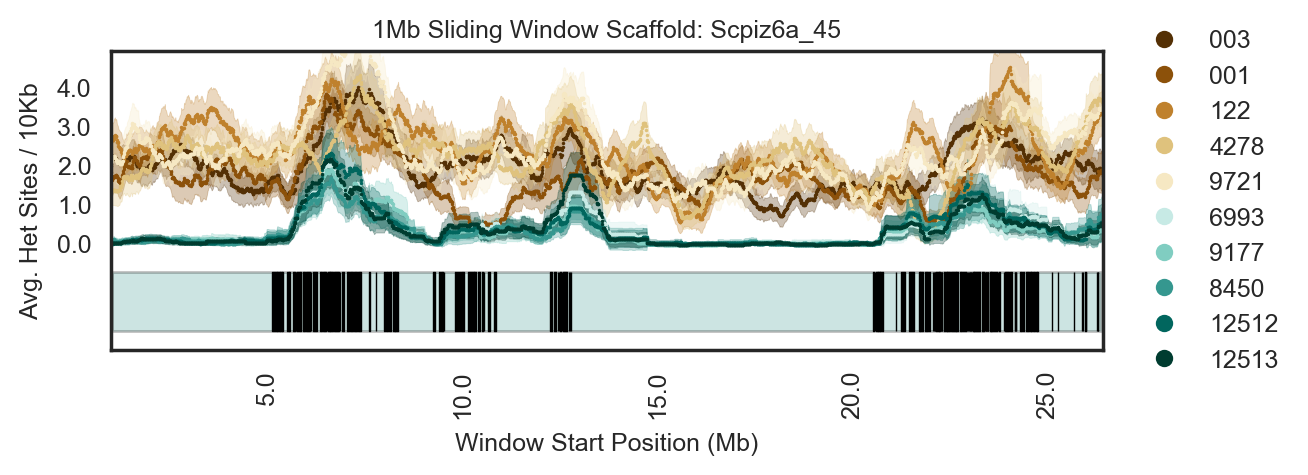

In [192]:
fig = plt.figure(1, figsize=(6.4, 1.93), dpi=200)
ax = fig.add_subplot(111)
step=100
scaffold='Scpiz6a_45'
lns = None
for animal in animal_ids:
    scaffold_het_rolling = equalHetWindowsDF[(equalHetWindowsDF['animal']==animal) & (equalHetWindowsDF['chrom']==scaffold)].reset_index().het_sites.rolling(window=step)
    ln1 = ax.plot(scaffold_het_rolling.mean(),
           '.',
            color=color_ids[animal],
            label=id_to_name[animal],
            markersize=2.5,
                 rasterized=True)

    ax.fill_between(scaffold_het_rolling.mean().index, 
                     scaffold_het_rolling.mean()-2*scaffold_het_rolling.std()/np.sqrt(step), 
                     scaffold_het_rolling.mean()+2*scaffold_het_rolling.std()/np.sqrt(step), 
                     color=color_ids[animal], 
                     alpha=0.3,
                   rasterized=True)
    if not lns:
        lns = ln1
    else:
        lns+=ln1
    
ax.set_ylim(-2.7, 5)    
ax.set_yticks(np.arange(0,5.0,1.0))
ax.set_yticklabels(ax.get_yticks(), fontsize=minorFontSize)
ax.set_ylabel('Avg. Het Sites / 10Kb', fontsize=minorFontSize)


megabase_labels = [str((x*10000/1000000)) for x in ax.get_xticks()]
ax.set_xticklabels(megabase_labels,rotation=90, fontsize=minorFontSize) 
ax.set_xlabel("Window Start Position (Mb)", fontsize=minorFontSize)

ax.set_title('%dMb Sliding Window Scaffold: %s' % (step*10000/1000000, scaffold), fontsize=minorFontSize)
ax.set_xlim(scaffold_het_rolling.mean().dropna().index.min(),scaffold_het_rolling.mean().dropna().index.max())

labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=5, bbox_to_anchor=(1.20, 0.5),markerscale=5, fontsize=minorFontSize)



chrom = ax.add_collection(BrokenBarHCollection(
        [(scaffold_het_rolling.mean().dropna().index.min()+2, scaffold_het_rolling.mean().dropna().index.max()-105)], 
        (-2.2,1.5),
        facecolors=color_ids['A_tigris8450'],
        alpha=0.25,
        linewidths=[1]
                                      )
    )


ax.add_collection(BrokenBarHCollection(
        vmnrDF[vmnrDF['feature']=='gene'].broken_bars, 
        (-2.2,1.5),
        facecolors=['black' for i in xrange(len(vmnrDF.broken_bars))],
        linewidths=[0.5 for i in xrange(len(vmnrDF.broken_bars))]
                                      )
    )
fig.savefig('../fig2/Figure4B.pdf', bbox_inches='tight', )

In [193]:
vmnrCopyNumbers = pd.read_csv('../../dovetail_vomeronasal/data/vmnrCopyNumsDF.csv')

In [194]:
vmnrCopyNumbers.head()

,Unnamed: 0,seqnames,start,end,width,strand,source,type,score,phase,...,similarity,insertions,deletions,intron_id,splice_site,alignment_id,Query,Align,frameshifts,cnv
0,1,Scpiz6a_49,64908337,64910441,2105,+,exonerate:protein2genome:local,gene,683.0,NaN,...,63.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN1
1,2,Scpiz6a_49,64908337,64908463,127,+,exonerate:protein2genome:local,cds,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN1
2,3,Scpiz6a_49,64908337,64908463,127,+,exonerate:protein2genome:local,exon,NaN,NaN,...,69.05,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,CN1
3,4,Scpiz6a_49,64908464,64908465,2,+,exonerate:protein2genome:local,splice5,NaN,NaN,...,NaN,NaN,NaN,1.0,GT,NaN,NaN,NaN,NaN,CN1
4,5,Scpiz6a_49,64908464,64909578,1115,+,exonerate:protein2genome:local,intron,NaN,NaN,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,CN1


In [195]:
vmnrCopyNumbers['copies'] = vmnrCopyNumbers['cnv'].apply(lambda x: int(x[2]))
vmnrCopyNumbers['broken_bars'] = vmnrCopyNumbers.apply(lambda row: (row['start']/10000, row['width']/10000), axis=1)
vmnrCopyNumbers.head()

,Unnamed: 0,seqnames,start,end,width,strand,source,type,score,phase,...,deletions,intron_id,splice_site,alignment_id,Query,Align,frameshifts,cnv,copies,broken_bars
0,1,Scpiz6a_49,64908337,64910441,2105,+,exonerate:protein2genome:local,gene,683.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN1,1,"(6490.8337, 0.2105)"
1,2,Scpiz6a_49,64908337,64908463,127,+,exonerate:protein2genome:local,cds,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CN1,1,"(6490.8337, 0.0127)"
2,3,Scpiz6a_49,64908337,64908463,127,+,exonerate:protein2genome:local,exon,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,CN1,1,"(6490.8337, 0.0127)"
3,4,Scpiz6a_49,64908464,64908465,2,+,exonerate:protein2genome:local,splice5,NaN,NaN,...,NaN,1.0,GT,NaN,NaN,NaN,NaN,CN1,1,"(6490.8464, 0.0002)"
4,5,Scpiz6a_49,64908464,64909578,1115,+,exonerate:protein2genome:local,intron,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,CN1,1,"(6490.8464, 0.1115)"


In [196]:
exon_lengths = []
exon_length= None
for row in vmnrCopyNumbers.itertuples():
    if row[8] == 'gene':
        if not exon_length:
            i=1
            exon_length = 0
            continue
        else:
            exon_length = [exon_length]*i
            exon_lengths.extend(exon_length)
            exon_length = 0
            i=0
    if row[8] == "exon":
        exon_length+=row[5]
    i+=1

exon_length = [exon_length]*i
exon_lengths.extend(exon_length)    
    
vmnrCopyNumbers['sum_exon_lengths'] = exon_lengths
vmnrCopyNumbers.head()

,Unnamed: 0,seqnames,start,end,width,strand,source,type,score,phase,...,intron_id,splice_site,alignment_id,Query,Align,frameshifts,cnv,copies,broken_bars,sum_exon_lengths
0,1,Scpiz6a_49,64908337,64910441,2105,+,exonerate:protein2genome:local,gene,683.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,CN1,1,"(6490.8337, 0.2105)",990
1,2,Scpiz6a_49,64908337,64908463,127,+,exonerate:protein2genome:local,cds,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,CN1,1,"(6490.8337, 0.0127)",990
2,3,Scpiz6a_49,64908337,64908463,127,+,exonerate:protein2genome:local,exon,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,CN1,1,"(6490.8337, 0.0127)",990
3,4,Scpiz6a_49,64908464,64908465,2,+,exonerate:protein2genome:local,splice5,NaN,NaN,...,1.0,GT,NaN,NaN,NaN,NaN,CN1,1,"(6490.8464, 0.0002)",990
4,5,Scpiz6a_49,64908464,64909578,1115,+,exonerate:protein2genome:local,intron,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,CN1,1,"(6490.8464, 0.1115)",990


In [197]:
len(vmnrCopyNumbers[(vmnrCopyNumbers.seqnames == 'Scpiz6a_45') & (vmnrCopyNumbers['score']>1000) &(vmnrCopyNumbers['type'] == 'gene')])

196

In [198]:
vmnrCopyNumbers[(vmnrCopyNumbers.seqnames == 'Scpiz6a_45') & (vmnrCopyNumbers['score']>1000) & (vmnrCopyNumbers['type'] == 'gene')].copies.sum()

206

In [199]:
len(vmnrCopyNumbers[(vmnrCopyNumbers['type']=='gene') & (vmnrCopyNumbers['score']>1000)])

205

In [200]:
vmnrCopyNumbers[(vmnrCopyNumbers['type']=='gene') & ((vmnrCopyNumbers['score']>1000))].copies.sum()

215

In [201]:
len(vmnrCopyNumbers[(vmnrCopyNumbers.seqnames == 'Scpiz6a_45') & (vmnrCopyNumbers['score']>800) &(vmnrCopyNumbers['type'] == 'gene')])

309

In [202]:
vmnrCopyNumbers[(vmnrCopyNumbers.seqnames == 'Scpiz6a_45') & (vmnrCopyNumbers['score']>800) & (vmnrCopyNumbers['type'] == 'gene')].copies.sum()

319

In [203]:
len(vmnrCopyNumbers[(vmnrCopyNumbers['type']=='gene') & (vmnrCopyNumbers['score']>800)])

466

In [204]:
vmnrCopyNumbers[(vmnrCopyNumbers['type']=='gene') & ((vmnrCopyNumbers['score']>800))].copies.sum()

478

In [205]:
sorted(vmnrCopyNumbers[vmnrCopyNumbers['type']=='exon']['broken_bars'], key = lambda x: x[1])[0]

(738.6374, 0.0002)

In [206]:
sorted(vmnrCopyNumbers[vmnrCopyNumbers['type']=='gene']['broken_bars'], key = lambda x: x[1])[0]

(9.7566, 0.0072)

In [207]:
vmnrCopyNumbers.cnv.unique()

array(['CN1', 'CN3', 'CN4'], dtype=object)